# <a id='toc1_'></a>[TWO MOONS DATASET EXPERIMENTS](#toc0_)

The purpose of this notebook will be to analyze the behavior of the networks on a toy task, namely: the two moons dataset. This dataset is a simple binary classification task, where the goal is to separate two half-moon shaped clusters. The dataset is generated using the `make_moons` function from `sklearn.datasets`.

We want to see if the network manages to have uncertainty in the regions where the two moons are close to each other, and if it is able to correctly classify the points in the two moons.

This experiment will be conducted on both Deep Neural Networks (DNNs) and Binary Neural Networks (BiNNs).

**Table of contents**<a id='toc0_'></a>    
- [TWO MOONS DATASET EXPERIMENTS](#toc1_)    
  - [Imports](#toc1_1_)    
  - [Train / test split](#toc1_2_)    
  - [Global variables](#toc1_3_)    
  - [Deep Neural Network](#toc1_4_)    
    - [Configuration and training of the network](#toc1_4_1_)    
    - [Exploiting the results](#toc1_4_2_)    
  - [Binary Neural Networks](#toc1_5_)    
    - [Configuration and training of the network](#toc1_5_1_)    
    - [Exploiting the results](#toc1_5_2_)    
    - [Straight Through Estimator with tanh](#toc1_5_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Imports](#toc0_)
Importing libraries and setting the global variables

In [1]:

from utils import *
from dataloader import *
import models
import torch
import trainer
from optimizer import *
from sklearn.datasets import make_moons
import palettable
from torch.utils.data import DataLoader, TensorDataset
from models.layers.activation import Sign

SEED = 0  # Random seed
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### SEED ###
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.set_default_device(DEVICE)
    torch.set_default_dtype(torch.float32)
np.random.seed(SEED)
torch.manual_seed(SEED)
    

/home/kellian/micromamba/envs/binarized-clone/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## <a id='toc1_2_'></a>[Train / test split](#toc0_)

We split the dataset into a train and test set. The test set will be used to evaluate the performance of the network, while the train set will be used to train the network. We separate the data into:
- `x_train`: the input data for the training set with 1024 points
- `y_train`: the labels for the training set with 1024 points
- `x_test`: the input data for the test set with 256 points
- `y_test`: the labels for the test set with 256 points

In [2]:
tr_size = 250
te_size = 50

### CREATE TWO MOONS DATASET ###
X, y = make_moons(n_samples=tr_size+te_size, noise=0.1, random_state=SEED)

# normalize dataset
X = (X - X.mean(axis=0)) / X.std(axis=0)

X_train = X[:tr_size]
y_train = y[:tr_size]
X_test = X[tr_size:]
y_test = y[tr_size:]

INPUT_SIZE = X_train.shape[1]

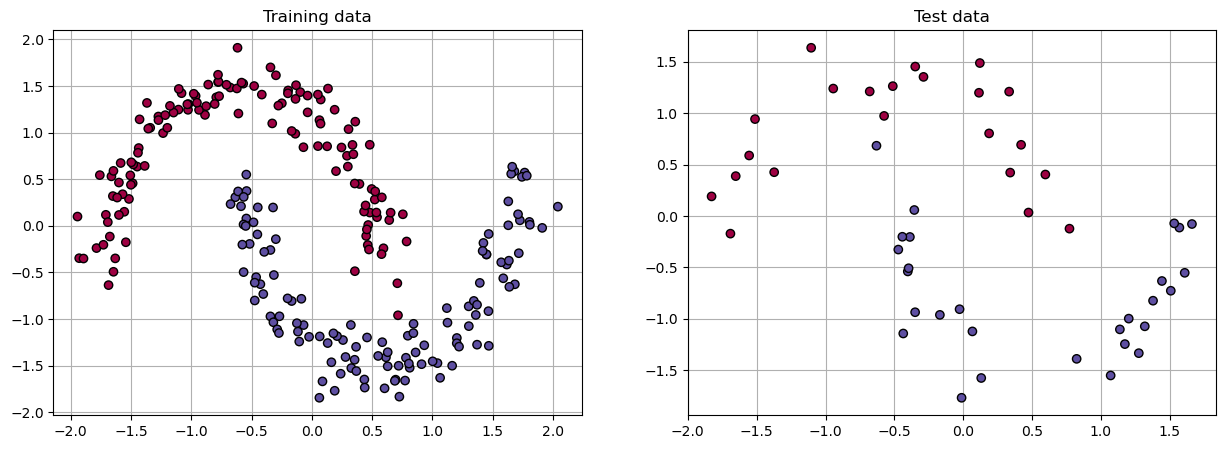

In [3]:
### PLOT X, y ###
# subplot for training data and test data
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].grid(True)
ax[1].grid(True)
ax[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Spectral, edgecolors='k', zorder=2)
ax[0].set_title("Training data")
ax[1].scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.Spectral, edgecolors='k', zorder=2)
ax[1].set_title("Test data")
plt.show()

## <a id='toc1_3_'></a>[Global variables](#toc0_)

In [4]:

# Global parameters
SOFTMAX = False

LAYER_SIZE = [128, 128]
EPOCHS = 3000
BATCH_SIZE = tr_size
LEARNING_RATE = 0.0001

if not SOFTMAX:
    SAVE_FOLDER = "saved-two-moons"
    OUT = 1
    OUTPUT_FUNCTION = "sigmoid"
    CRITERION = torch.functional.F.binary_cross_entropy
else:
    SAVE_FOLDER = "saved-two-moons-softmax"
    OUT = 2
    OUTPUT_FUNCTION = "log_softmax"
    CRITERION = torch.functional.F.nll_loss

## <a id='toc1_4_'></a>[Deep Neural Network](#toc0_)

### <a id='toc1_4_1_'></a>[Configuration and training of the network](#toc0_)

We configure the network by setting the parameters within a dictionary.

In [5]:

### NETWORK CONFIGURATION ###
network_data = {
    "nn_type": models.DNN,
    "nn_parameters": {
        "layers": [INPUT_SIZE] + LAYER_SIZE + [OUT],
        "device": DEVICE,
        "dropout": False, # Dropout layers
        "batchnorm": False, # Batch normalization layers
        "bias": True,
        "latent_weights": False, # Latent weights for BNN
        "activation_function": torch.functional.F.tanh, # Activation function for hidden layers
        "output_function": OUTPUT_FUNCTION, # Activation function for output layer (as loss function is BCE_with_logits, no activation function is needed)
    },
    "training_parameters": {
        'n_epochs': EPOCHS,
        'batch_size': BATCH_SIZE,
        'test_mcmc_samples': 1,
    },
    "criterion": CRITERION,
    "optimizer": BayesBiNN,
    "optimizer_parameters": {
        "temperature": 1,
        "num_mcmc_samples": 10,
        "init_lambda": 5,
        "lr": LEARNING_RATE,
        "beta": 0.99
    },
}

train_tensor = GPUTensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
test_tensor = GPUTensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

if "binary_cross_entropy" in network_data["criterion"].__name__:
    train_tensor.targets = train_tensor.targets.float().unsqueeze(1)
    test_tensor.targets = test_tensor.targets.float().unsqueeze(1)

train_loader = GPUDataLoader(train_tensor, batch_size=network_data["training_parameters"]["batch_size"], shuffle=True)
test_loader = GPUDataLoader(test_tensor, batch_size=te_size, shuffle=False)

### SEED ###
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

### ACCURACY INITIALIZATION ###
accuracies = []
batch_size = network_data['training_parameters']['batch_size']

### NETWORK INITIALIZATION ###
model = network_data['nn_type'](**network_data['nn_parameters'])

### INSTANTIATE THE TRAINER ###
network = trainer.BayesTrainer(batch_size=batch_size,
                                model=model, **network_data, device=DEVICE)
### TRAINING ###
network.fit(
    train_loader, 
    **network_data['training_parameters'], 
    test_loader=[test_loader, train_loader],
    name_loader=["Test accuracy", "Train accuracy"]
)

Epoch 19/3000:   0%|          | 12/3000 [00:00<00:47, 62.26it/s, loss=1.24]

Testing accuracy: 
	Test accuracy: 36.00%
	Train accuracy: 40.00%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 42.00%
	Train accuracy: 30.80%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 50.40%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 11.20%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 52.80%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 47.60%
Testing accuracy: 
	Test accuracy: 38.00%
	Train accuracy: 69.60%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 67.60%
Testing accuracy: 
	Test accuracy: 46.00%
	Train accuracy: 78.80%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 74.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 45.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 51.60%
Testing ac

Epoch 38/3000:   1%|          | 32/3000 [00:00<00:35, 82.99it/s, loss=1.52] 

Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 74.00%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 70.80%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 78.40%
Testing accuracy: 
	Test accuracy: 54.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 36.00%
	Train accuracy: 65.20%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 56.40%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 68.40%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 76.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 80.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 68.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 67.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 75.60%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 62.40%
Testing ac

Epoch 54/3000:   2%|▏         | 51/3000 [00:00<00:35, 83.99it/s, loss=1.53] 

Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 77.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 75.20%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 76.00%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 80.80%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 73.20%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 33.60%


Epoch 68/3000:   2%|▏         | 68/3000 [00:00<00:38, 75.38it/s, loss=0.999]

Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 72.80%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 68.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 66.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 54.40%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 81.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 92.40%


Epoch 88/3000:   3%|▎         | 87/3000 [00:01<00:35, 83.19it/s, loss=1.2]  

Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 66.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 76.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 72.40%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 80.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 79.20%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 81.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 79.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 81.60%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 55.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 79.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 82.80%
Testing ac

Epoch 104/3000:   3%|▎         | 96/3000 [00:01<00:34, 83.46it/s, loss=1.09] 

Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 76.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 72.40%
Testing accuracy: 
	Test accuracy: 46.00%
	Train accuracy: 70.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 60.00%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 74.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 75.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 58.00%
Testing ac

Epoch 123/3000:   4%|▍         | 115/3000 [00:01<00:33, 86.63it/s, loss=1.23] 

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 79.20%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 80.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 87.20%
Testing ac

Epoch 141/3000:   4%|▍         | 133/3000 [00:01<00:33, 85.51it/s, loss=0.794]

Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 79.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 80.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 64.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 80.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 76.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 90.80%
Testing ac

Epoch 159/3000:   5%|▌         | 153/3000 [00:01<00:32, 88.58it/s, loss=0.853]

	Test accuracy: 92.00%
	Train accuracy: 61.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 77.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 76.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 81.20%
Testing accuracy: 
	Test accu

Epoch 177/3000:   6%|▌         | 173/3000 [00:02<00:31, 90.78it/s, loss=0.884]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 60.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 69.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 77.20%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 76.80%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 77.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 81.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 74.40%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 90.40%
Testing ac

Epoch 195/3000:   6%|▋         | 192/3000 [00:02<00:32, 87.48it/s, loss=1.06] 

Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 78.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 71.60%
Testing ac

Epoch 213/3000:   7%|▋         | 211/3000 [00:02<00:32, 87.08it/s, loss=0.766]

Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 76.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 90.40%
Testing ac

Epoch 229/3000:   8%|▊         | 229/3000 [00:02<00:32, 84.07it/s, loss=0.835]

	Test accuracy: 88.00%
	Train accuracy: 79.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 53.20%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 57.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 51.60%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 76.40%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 80.80%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accu

Epoch 248/3000:   8%|▊         | 238/3000 [00:02<00:32, 84.63it/s, loss=0.659]

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 73.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 75.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 78.80%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 74.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 78.00%
Testing ac

Epoch 266/3000:   9%|▊         | 258/3000 [00:03<00:30, 89.18it/s, loss=0.613]

Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 81.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 69.60%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 58.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 73.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 78.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 81.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 76.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 82.00%
Testing ac

Epoch 283/3000:   9%|▉         | 276/3000 [00:03<00:31, 86.36it/s, loss=0.557]

Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 79.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 72.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 67.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 72.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 87.20%
Testing ac

Epoch 302/3000:  10%|▉         | 294/3000 [00:03<00:31, 86.31it/s, loss=0.437]

Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 81.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 76.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 72.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 54.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 67.60%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 90.40%
Testing ac

Epoch 321/3000:  10%|█         | 314/3000 [00:03<00:29, 90.72it/s, loss=0.413]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 74.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 76.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 70.80%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 81.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 86.80%
Testing ac

Epoch 340/3000:  11%|█         | 334/3000 [00:03<00:28, 93.91it/s, loss=0.7]  

Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 79.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 60.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 81.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 66.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 81.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 87.20%
Testing ac

Epoch 359/3000:  12%|█▏        | 354/3000 [00:04<00:29, 89.61it/s, loss=0.389]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 81.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 57.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 57.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 61.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 81.60%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 86.00%
Testing ac

Epoch 377/3000:  12%|█▏        | 374/3000 [00:04<00:28, 91.86it/s, loss=0.513]

Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 60.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 48.00%
	Train accuracy: 45.20%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 55.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 65.20%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 60.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing ac

Epoch 394/3000:  13%|█▎        | 393/3000 [00:04<00:29, 88.29it/s, loss=0.366]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 46.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 36.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 65.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 62.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 84.40%
Testing ac

Epoch 414/3000:  14%|█▎        | 412/3000 [00:04<00:28, 89.56it/s, loss=0.244]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 79.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 74.00%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 74.80%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 81.60%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 58.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 63.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 80.80%
Testing ac

Epoch 430/3000:  14%|█▍        | 422/3000 [00:05<00:28, 89.93it/s, loss=0.321]

Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 75.20%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 71.60%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 80.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 74.80%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 90.80%
Testing ac

Epoch 449/3000:  15%|█▍        | 442/3000 [00:05<00:29, 86.73it/s, loss=0.29] 

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 48.00%
	Train accuracy: 71.20%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 55.60%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 76.80%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 57.60%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 72.80%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 54.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 71.60%
Testing ac

Epoch 466/3000:  15%|█▌        | 462/3000 [00:05<00:28, 88.49it/s, loss=0.279]

Testing accuracy: 
	Test accuracy: 50.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 68.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 80.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 54.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 78.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 91.60%
Testing ac

Epoch 484/3000:  16%|█▌        | 481/3000 [00:05<00:28, 87.03it/s, loss=0.371]

Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 67.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 50.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 50.40%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 86.00%
Testing ac

Epoch 502/3000:  17%|█▋        | 501/3000 [00:05<00:28, 87.44it/s, loss=0.246]

Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 60.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 58.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 69.60%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 94.40%
Testing ac

Epoch 519/3000:  17%|█▋        | 519/3000 [00:06<00:28, 85.83it/s, loss=0.287]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 65.20%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 77.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 76.80%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 68.80%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 75.60%
Testing ac

Epoch 538/3000:  18%|█▊        | 529/3000 [00:06<00:28, 87.75it/s, loss=0.531]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 66.80%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 72.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 70.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 75.20%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 81.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 80.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 80.40%
Testing ac

Epoch 555/3000:  18%|█▊        | 548/3000 [00:06<00:28, 85.46it/s, loss=0.269]

Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 77.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 42.00%
	Train accuracy: 64.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 62.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 70.40%
Testing ac

Epoch 573/3000:  19%|█▉        | 566/3000 [00:06<00:28, 86.28it/s, loss=0.387]

Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 63.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 62.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 32.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 61.60%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 84.40%
Testing ac

Epoch 592/3000:  20%|█▉        | 585/3000 [00:06<00:27, 88.12it/s, loss=0.273]

Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 50.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 69.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 65.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 90.00%
Testing ac

Epoch 611/3000:  20%|██        | 605/3000 [00:07<00:26, 91.61it/s, loss=0.267]

Testing accuracy: 
	Test accuracy: 40.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 59.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 76.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 81.20%
Testing accuracy: 
	Test accuracy: 54.00%
	Train accuracy: 72.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing ac

Epoch 631/3000:  21%|██        | 625/3000 [00:07<00:25, 93.60it/s, loss=0.476]

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 50.00%
	Train accuracy: 72.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 88.00%
Testing ac

Epoch 650/3000:  22%|██▏       | 645/3000 [00:07<00:25, 92.82it/s, loss=0.287]

Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 78.40%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 73.60%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 79.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 67.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 80.80%
Testing ac

Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 78.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 57.20%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 64.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 55.60%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 56.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 84.00%
Testing ac

Epoch 686/3000:  23%|██▎       | 685/3000 [00:07<00:25, 89.91it/s, loss=0.227]

	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 78.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 71.20%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 68.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 78.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 79.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train acc

Epoch 704/3000:  23%|██▎       | 695/3000 [00:08<00:25, 91.47it/s, loss=0.315]

Testing accuracy: 
	Test accuracy: 48.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 54.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 72.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 58.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 89.60%
Testing ac

Epoch 723/3000:  24%|██▍       | 715/3000 [00:08<00:25, 90.34it/s, loss=0.189]

Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 62.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 70.00%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 73.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 90.00%
Testing ac

Epoch 741/3000:  24%|██▍       | 735/3000 [00:08<00:25, 88.24it/s, loss=0.191]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 79.20%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 81.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 88.00%
Testing ac

Epoch 760/3000:  25%|██▌       | 755/3000 [00:08<00:24, 90.47it/s, loss=0.281]

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 78.80%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 69.60%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 92.00%
Testing ac

Epoch 779/3000:  26%|██▌       | 775/3000 [00:08<00:24, 90.85it/s, loss=0.185]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 66.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 76.00%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 66.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 56.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 64.40%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 58.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 86.00%
Testing ac

Epoch 798/3000:  26%|██▋       | 795/3000 [00:09<00:23, 92.74it/s, loss=0.223]

Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 60.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 70.00%
Testing accuracy: 
	Test accuracy: 50.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 73.20%
Testing accuracy: 
	Test accuracy: 54.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 76.00%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 61.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 74.40%
Testing ac

Epoch 817/3000:  27%|██▋       | 815/3000 [00:09<00:23, 93.16it/s, loss=0.241]

Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 63.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 71.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 73.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 60.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 48.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 73.20%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 69.60%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 93.20%
Testing ac

Epoch 837/3000:  28%|██▊       | 835/3000 [00:09<00:22, 94.52it/s, loss=0.301]

Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 53.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 74.40%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 80.80%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 81.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 80.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 80.00%
Testing ac

Epoch 854/3000:  28%|██▊       | 845/3000 [00:09<00:22, 95.63it/s, loss=0.398]

Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 61.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 82.40%
Testing ac

Epoch 873/3000:  29%|██▉       | 865/3000 [00:09<00:24, 88.43it/s, loss=0.229]

Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 76.40%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 40.40%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 74.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 84.80%
Testing ac

Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 58.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 60.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 74.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 67.60%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 62.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 90.00%
Testing ac

Epoch 908/3000:  30%|███       | 904/3000 [00:10<00:23, 87.75it/s, loss=0.308]

Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 77.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 78.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 73.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 93.60%
Testing ac

Epoch 925/3000:  31%|███       | 922/3000 [00:10<00:24, 83.84it/s, loss=0.227]

Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 72.40%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 74.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 81.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 61.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 71.20%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 72.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 79.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 87.20%
Testing ac

Epoch 943/3000:  31%|███▏      | 941/3000 [00:10<00:24, 84.69it/s, loss=0.237]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 81.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 61.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 69.60%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 74.80%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 67.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 80.40%
Testing ac

Epoch 960/3000:  32%|███▏      | 950/3000 [00:10<00:24, 82.97it/s, loss=0.232] 

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 76.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 70.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 95.60%
Testing ac

Epoch 978/3000:  32%|███▏      | 970/3000 [00:11<00:23, 88.05it/s, loss=0.234]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 58.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 72.00%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 63.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 78.00%
Testing ac

Epoch 997/3000:  33%|███▎      | 989/3000 [00:11<00:22, 90.25it/s, loss=0.205]

Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 80.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 74.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 64.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 84.00%
Testing ac

Epoch 1015/3000:  34%|███▎      | 1008/3000 [00:11<00:22, 89.69it/s, loss=0.116]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 74.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 78.40%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 81.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 70.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 81.60%
Testing ac

Epoch 1031/3000:  34%|███▍      | 1027/3000 [00:11<00:22, 87.34it/s, loss=0.145]

	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 81.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 76.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 64.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train acc

Epoch 1048/3000:  35%|███▍      | 1045/3000 [00:11<00:23, 82.46it/s, loss=0.151]

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 77.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 78.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 70.00%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 65.20%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 78.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 89.20%
Testing ac

Epoch 1066/3000:  35%|███▌      | 1064/3000 [00:12<00:22, 84.67it/s, loss=0.161]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 78.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 81.20%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 80.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 66.00%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 74.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 79.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 54.00%
	Train accuracy: 82.00%
Testing ac

Epoch 1083/3000:  36%|███▌      | 1083/3000 [00:12<00:22, 85.28it/s, loss=0.173]

	Test accuracy: 90.00%
	Train accuracy: 73.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 79.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 69.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 73.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 75.20%
Testing accuracy: 
	Test accu

Epoch 1101/3000:  36%|███▋      | 1092/3000 [00:12<00:22, 83.07it/s, loss=0.201]

Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 71.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 79.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 50.00%
	Train accuracy: 79.20%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 75.60%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 87.60%
Testing ac

Epoch 1117/3000:  37%|███▋      | 1111/3000 [00:12<00:22, 85.11it/s, loss=0.189] 

Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 78.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 79.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 60.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 86.00%
Testing ac

Epoch 1131/3000:  38%|███▊      | 1129/3000 [00:12<00:23, 78.01it/s, loss=0.104]

Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 72.40%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 71.60%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 74.40%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 79.20%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 90.80%


Epoch 1146/3000:  38%|███▊      | 1145/3000 [00:13<00:25, 73.40it/s, loss=0.232]

Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 72.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 48.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 81.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 91.60%


Epoch 1163/3000:  38%|███▊      | 1155/3000 [00:13<00:23, 78.61it/s, loss=0.196]

Testing accuracy: 
	Test accuracy: 46.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 64.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 81.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 80.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 89.20%
Testing ac

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 78.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 71.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 80.80%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 86.00%
Testing a

Epoch 1199/3000:  40%|███▉      | 1192/3000 [00:13<00:21, 85.62it/s, loss=0.278] 

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 88.40%
Testing ac

Epoch 1218/3000:  40%|████      | 1211/3000 [00:14<00:20, 87.24it/s, loss=0.262]

Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 79.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 63.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 77.20%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 90.00%
Testing ac

Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 66.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 81.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 78.80%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 69.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.00%
Testing ac

Epoch 1254/3000:  42%|████▏     | 1248/3000 [00:14<00:19, 89.49it/s, loss=0.204] 

	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 76.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 78.40%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 80.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 80.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 70.00%
	Train acc

Epoch 1272/3000:  42%|████▏     | 1268/3000 [00:14<00:18, 91.30it/s, loss=0.137]

Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 61.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 85.60%
Testing ac

Epoch 1291/3000:  43%|████▎     | 1288/3000 [00:14<00:18, 91.18it/s, loss=0.253] 

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 72.40%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 77.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 79.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 76.00%
Testing accuracy: 
	Test accuracy: 54.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 87.60%
Testing ac

Epoch 1310/3000:  44%|████▎     | 1308/3000 [00:15<00:18, 91.10it/s, loss=0.208] 

Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 74.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 80.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 79.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 64.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 72.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 78.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 86.00%
Testing ac

Epoch 1328/3000:  44%|████▍     | 1328/3000 [00:15<00:18, 90.74it/s, loss=0.225] 

	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 54.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 80.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 61.20%
Testing accuracy: 
	Test accuracy: 82.00%
	Train a

Epoch 1345/3000:  45%|████▍     | 1338/3000 [00:15<00:18, 91.52it/s, loss=0.159]

Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 74.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 78.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 79.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 78.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 79.20%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 88.80%
Testing ac

Epoch 1362/3000:  45%|████▌     | 1357/3000 [00:15<00:19, 84.90it/s, loss=0.172] 

Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 70.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 62.40%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 62.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 53.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 66.80%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 82.40%
Testing ac

Epoch 1379/3000:  46%|████▌     | 1375/3000 [00:15<00:19, 83.14it/s, loss=0.217] 

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 46.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 86.00%
Testing ac

Epoch 1397/3000:  46%|████▋     | 1395/3000 [00:16<00:18, 88.14it/s, loss=0.156]

	Test accuracy: 86.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 73.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 50.00%
	Train accuracy: 57.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accu

Epoch 1416/3000:  47%|████▋     | 1414/3000 [00:16<00:17, 89.57it/s, loss=0.244] 

Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 65.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 89.20%
Testing ac

Epoch 1435/3000:  48%|████▊     | 1434/3000 [00:16<00:17, 91.56it/s, loss=0.192]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 72.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 67.60%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 76.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 66.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 70.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 89.20%
Testing ac

Epoch 1453/3000:  48%|████▊     | 1444/3000 [00:16<00:17, 87.37it/s, loss=0.216]

Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 77.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 68.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 74.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 89.60%
Testing ac

Epoch 1469/3000:  49%|████▉     | 1464/3000 [00:16<00:17, 86.57it/s, loss=0.137] 

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 71.20%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 73.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 71.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 80.00%
Testing ac

Epoch 1489/3000:  49%|████▉     | 1483/3000 [00:17<00:17, 88.60it/s, loss=0.145] 

Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 81.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 75.60%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 75.60%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 76.80%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 88.80%
Testing ac

Epoch 1508/3000:  50%|█████     | 1503/3000 [00:17<00:16, 91.79it/s, loss=0.157]

Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 73.60%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 93.20%
Testing ac

Epoch 1527/3000:  51%|█████     | 1523/3000 [00:17<00:16, 90.66it/s, loss=0.135] 

Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 64.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 74.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 77.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 50.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 64.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 71.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 53.60%
Testing ac

Epoch 1546/3000:  51%|█████▏    | 1543/3000 [00:17<00:15, 91.85it/s, loss=0.142] 

Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 74.80%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 81.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 68.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 70.80%
Testing ac

Epoch 1564/3000:  52%|█████▏    | 1563/3000 [00:17<00:16, 89.66it/s, loss=0.274]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 54.00%
	Train accuracy: 54.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 85.20%
Testing ac

Epoch 1579/3000:  52%|█████▏    | 1572/3000 [00:18<00:16, 84.70it/s, loss=0.257] 

Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 76.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 64.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 73.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 54.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 62.40%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 94.80%


Epoch 1595/3000:  53%|█████▎    | 1590/3000 [00:18<00:18, 78.32it/s, loss=0.0885]

Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 65.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 68.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 90.00%
Testing ac

Epoch 1610/3000:  54%|█████▎    | 1608/3000 [00:18<00:17, 79.26it/s, loss=0.158] 

Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 66.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 75.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 74.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 74.80%


Epoch 1627/3000:  54%|█████▍    | 1626/3000 [00:18<00:16, 81.18it/s, loss=0.183]

Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 76.00%
Testing accuracy: 
	Test accuracy: 42.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 72.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 80.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 92.00%
Testing ac

Epoch 1646/3000:  55%|█████▍    | 1645/3000 [00:18<00:15, 85.93it/s, loss=0.188]

Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 64.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 74.80%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 93.20%
Testing ac

Epoch 1662/3000:  55%|█████▌    | 1654/3000 [00:19<00:16, 82.53it/s, loss=0.185]

Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 54.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 81.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 79.20%
Testing ac

Epoch 1679/3000:  56%|█████▌    | 1672/3000 [00:19<00:15, 83.70it/s, loss=0.163]

Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 81.60%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 66.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 57.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 78.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 78.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 88.40%
Testing ac

Epoch 1697/3000:  56%|█████▋    | 1690/3000 [00:19<00:15, 83.23it/s, loss=0.203] 

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 78.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 77.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 67.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 82.40%
Testing 

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 75.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 74.00%
Testing accuracy: 
	Test accuracy: 50.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 86.00%
Testing ac

Epoch 1732/3000:  58%|█████▊    | 1728/3000 [00:19<00:14, 88.13it/s, loss=0.111]

Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 68.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 78.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 67.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 86.80%
Testing ac

Epoch 1749/3000:  58%|█████▊    | 1747/3000 [00:20<00:14, 84.73it/s, loss=0.104]

Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 79.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 81.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 64.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 54.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 64.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 85.20%
Testing ac

Epoch 1766/3000:  59%|█████▉    | 1765/3000 [00:20<00:14, 84.02it/s, loss=0.165] 

Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 53.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 78.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 91.60%
Testing ac

Epoch 1784/3000:  59%|█████▉    | 1784/3000 [00:20<00:14, 85.57it/s, loss=0.228] 

Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 76.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 69.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 87.20%
Testing ac

Epoch 1801/3000:  60%|█████▉    | 1793/3000 [00:20<00:14, 84.41it/s, loss=0.246] 

Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 81.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 81.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 76.40%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 71.20%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 75.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 81.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 86.80%
Testing ac

Epoch 1820/3000:  60%|██████    | 1812/3000 [00:20<00:13, 87.04it/s, loss=0.135] 

Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 76.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 88.00%
Testing ac

Epoch 1839/3000:  61%|██████    | 1832/3000 [00:21<00:12, 90.97it/s, loss=0.264] 

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 52.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 78.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 69.20%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 78.80%
Testing ac

Epoch 1858/3000:  62%|██████▏   | 1852/3000 [00:21<00:12, 91.29it/s, loss=0.172] 

Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 77.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 82.00%
Testing ac

Epoch 1876/3000:  62%|██████▏   | 1872/3000 [00:21<00:12, 90.14it/s, loss=0.253] 

Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 89.60%
Testing ac

Epoch 1891/3000:  63%|██████▎   | 1891/3000 [00:21<00:13, 81.66it/s, loss=0.14]  

Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 80.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 93.60%


Epoch 1907/3000:  63%|██████▎   | 1900/3000 [00:21<00:13, 82.37it/s, loss=0.235] 

Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 81.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 51.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 81.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 91.20%
Testing ac

Epoch 1926/3000:  64%|██████▍   | 1918/3000 [00:22<00:13, 81.45it/s, loss=0.121] 

Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 97.60%
Testing ac

Epoch 1943/3000:  65%|██████▍   | 1937/3000 [00:22<00:12, 84.58it/s, loss=0.169]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 72.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 60.00%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 91.20%
Testing ac

Epoch 1960/3000:  65%|██████▌   | 1955/3000 [00:22<00:12, 84.24it/s, loss=0.156] 

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 78.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 81.60%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 65.60%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 78.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 73.60%
Testing ac

Epoch 1979/3000:  66%|██████▌   | 1975/3000 [00:22<00:11, 89.15it/s, loss=0.0872]

	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 74.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 76.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 76.40%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train ac

Epoch 1996/3000:  66%|██████▋   | 1993/3000 [00:22<00:11, 86.72it/s, loss=0.187] 

	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 54.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 66.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 26.40%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 78.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 75.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 62.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 60.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train acc

Epoch 2011/3000:  67%|██████▋   | 2011/3000 [00:23<00:11, 82.77it/s, loss=0.0958]

Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 71.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 85.60%
Testing ac

Epoch 2029/3000:  67%|██████▋   | 2020/3000 [00:23<00:11, 84.00it/s, loss=0.175] 

Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 54.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 78.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 90.80%
Testing ac

Epoch 2048/3000:  68%|██████▊   | 2040/3000 [00:23<00:10, 88.99it/s, loss=0.213] 

Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 61.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 76.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 73.60%
Testing ac

Epoch 2065/3000:  69%|██████▊   | 2059/3000 [00:23<00:10, 89.81it/s, loss=0.103]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 65.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 86.40%
Testing ac

Epoch 2084/3000:  69%|██████▉   | 2077/3000 [00:24<00:10, 85.77it/s, loss=0.146] 

Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 76.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 78.00%
Testing ac

Epoch 2103/3000:  70%|██████▉   | 2097/3000 [00:24<00:09, 90.77it/s, loss=0.165] 

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 76.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 81.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 97.60%
Testing ac

Epoch 2119/3000:  71%|███████   | 2116/3000 [00:24<00:10, 86.03it/s, loss=0.07]  

	Train accuracy: 67.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train acc

Epoch 2137/3000:  71%|███████   | 2135/3000 [00:24<00:09, 89.50it/s, loss=0.246] 

	Test accuracy: 84.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 76.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accu

Epoch 2155/3000:  72%|███████▏  | 2154/3000 [00:24<00:09, 89.21it/s, loss=0.096] 

Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 76.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.80%
Testing ac

Epoch 2174/3000:  72%|███████▏  | 2173/3000 [00:25<00:09, 89.86it/s, loss=0.0873]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 69.20%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 89.20%
Testing ac

Epoch 2192/3000:  73%|███████▎  | 2192/3000 [00:25<00:09, 88.65it/s, loss=0.103] 

Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 79.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 46.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 81.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 66.00%
Testing ac

Epoch 2211/3000:  73%|███████▎  | 2201/3000 [00:25<00:09, 88.63it/s, loss=0.11]  

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 80.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 76.00%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 68.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 88.00%
Testing ac

	Test accuracy: 98.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 78.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 67.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accu

Epoch 2243/3000:  75%|███████▍  | 2238/3000 [00:25<00:09, 84.44it/s, loss=0.0952]

Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 72.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 78.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 81.60%
Testing ac

Epoch 2261/3000:  75%|███████▌  | 2256/3000 [00:26<00:09, 82.45it/s, loss=0.163] 

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 78.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 77.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 76.00%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 93.60%
Testing ac

Epoch 2277/3000:  76%|███████▌  | 2275/3000 [00:26<00:08, 82.13it/s, loss=0.101] 

Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 72.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 46.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 78.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 68.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 89.60%
Testing ac

Epoch 2296/3000:  76%|███████▋  | 2294/3000 [00:26<00:08, 86.72it/s, loss=0.16]  

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 81.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.00%
Testing ac

Epoch 2311/3000:  77%|███████▋  | 2303/3000 [00:26<00:09, 76.33it/s, loss=0.141] 

Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 76.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 94.40%


Epoch 2329/3000:  77%|███████▋  | 2323/3000 [00:26<00:08, 83.60it/s, loss=0.0728]

Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 70.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 97.20%
Testing ac

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 74.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 71.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 88.80%
Testing ac

Epoch 2361/3000:  79%|███████▊  | 2358/3000 [00:27<00:08, 79.14it/s, loss=0.0717]

	Test accuracy: 94.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 54.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 65.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 68.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accu

Epoch 2376/3000:  79%|███████▉  | 2376/3000 [00:27<00:08, 77.90it/s, loss=0.0691]

Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 74.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 80.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 92.00%


Epoch 2394/3000:  80%|███████▉  | 2394/3000 [00:27<00:07, 81.57it/s, loss=0.113] 

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 76.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 97.60%
Testing ac

Epoch 2413/3000:  80%|████████  | 2413/3000 [00:27<00:06, 86.27it/s, loss=0.146] 

Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 92.40%
Testing ac

Epoch 2432/3000:  81%|████████  | 2423/3000 [00:28<00:06, 87.71it/s, loss=0.105] 

Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 56.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 92.40%
Testing a

Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 60.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 79.20%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 44.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 76.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 81.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 85.20%
Testing ac

Epoch 2467/3000:  82%|████████▏ | 2461/3000 [00:28<00:06, 89.03it/s, loss=0.199] 

Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 74.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 72.80%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 78.80%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 54.40%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 74.00%
Testing ac

Epoch 2481/3000:  83%|████████▎ | 2479/3000 [00:28<00:06, 78.35it/s, loss=0.123] 

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 34.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 63.20%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 72.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 71.60%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 78.80%


Epoch 2494/3000:  83%|████████▎ | 2487/3000 [00:28<00:07, 70.81it/s, loss=0.214]

Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 74.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 71.60%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 60.80%


Epoch 2509/3000:  83%|████████▎ | 2503/3000 [00:29<00:06, 71.39it/s, loss=0.138] 

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 74.80%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 70.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 61.60%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 73.60%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 40.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 50.00%
	Train accuracy: 86.00%


Epoch 2525/3000:  84%|████████▍ | 2519/3000 [00:29<00:06, 73.96it/s, loss=0.142] 

Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 71.20%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 78.40%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 62.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 56.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 92.80%
Testing ac

Epoch 2539/3000:  85%|████████▍ | 2536/3000 [00:29<00:06, 72.94it/s, loss=0.182] 

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 64.40%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 80.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 76.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 76.40%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 65.60%


Epoch 2555/3000:  85%|████████▌ | 2553/3000 [00:29<00:06, 72.97it/s, loss=0.122] 

Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 33.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 64.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 80.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 76.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 76.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 80.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 92.00%
Testing ac

Epoch 2571/3000:  86%|████████▌ | 2570/3000 [00:29<00:05, 75.52it/s, loss=0.0754]

Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 72.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 91.20%
Testing ac

Epoch 2586/3000:  86%|████████▌ | 2586/3000 [00:30<00:05, 73.27it/s, loss=0.17]  

Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 75.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 74.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 91.60%


Epoch 2601/3000:  86%|████████▋ | 2594/3000 [00:30<00:05, 73.42it/s, loss=0.211] 

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 67.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 59.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 91.20%


Epoch 2617/3000:  87%|████████▋ | 2610/3000 [00:30<00:05, 74.10it/s, loss=0.145] 

Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 64.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 62.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 84.40%
Testing a

Epoch 2632/3000:  88%|████████▊ | 2626/3000 [00:30<00:05, 73.05it/s, loss=0.173] 

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 76.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 78.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 96.00%


Epoch 2648/3000:  88%|████████▊ | 2642/3000 [00:31<00:04, 73.35it/s, loss=0.225] 

Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 81.60%
Testing ac

Epoch 2664/3000:  89%|████████▊ | 2660/3000 [00:31<00:04, 77.18it/s, loss=0.152] 

Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 65.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 78.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 88.40%
Testing ac

Epoch 2680/3000:  89%|████████▉ | 2676/3000 [00:31<00:04, 75.60it/s, loss=0.162] 

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 81.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing ac

Epoch 2695/3000:  90%|████████▉ | 2692/3000 [00:31<00:04, 73.38it/s, loss=0.111] 

Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 77.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 87.60%


Epoch 2712/3000:  90%|█████████ | 2710/3000 [00:31<00:03, 78.53it/s, loss=0.11]  

Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 68.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 65.20%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 88.40%
Testing a

Epoch 2729/3000:  91%|█████████ | 2727/3000 [00:32<00:03, 80.01it/s, loss=0.126] 

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 81.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 76.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 84.00%
Testing a

Epoch 2746/3000:  92%|█████████▏| 2745/3000 [00:32<00:03, 80.56it/s, loss=0.145] 

Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 69.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 75.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 80.40%
Testing ac

Epoch 2760/3000:  92%|█████████▏| 2754/3000 [00:32<00:03, 77.48it/s, loss=0.0737]

Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 73.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 81.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 86.00%


Epoch 2776/3000:  92%|█████████▏| 2770/3000 [00:32<00:03, 76.53it/s, loss=0.181] 

Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 83.60%
Testing 

Epoch 2791/3000:  93%|█████████▎| 2787/3000 [00:32<00:02, 76.90it/s, loss=0.193] 

	Test accuracy: 94.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 81.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 81.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accu

Epoch 2807/3000:  93%|█████████▎| 2804/3000 [00:33<00:02, 75.67it/s, loss=0.247] 

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 71.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 88.00%


Epoch 2820/3000:  94%|█████████▍| 2820/3000 [00:33<00:02, 72.30it/s, loss=0.0448]

Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 78.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 70.80%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 90.40%


Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 71.20%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 77.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 90.40%


Epoch 2852/3000:  95%|█████████▍| 2844/3000 [00:33<00:02, 75.05it/s, loss=0.0866]

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 81.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 76.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 90.40%
Testing ac

Epoch 2863/3000:  95%|█████████▌| 2861/3000 [00:33<00:01, 72.27it/s, loss=0.0686]

	Test accuracy: 90.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 80.80%
Testing accuracy: 
	Test accuracy: 50.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 73.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 80.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 88.80%


Epoch 2878/3000:  96%|█████████▌| 2877/3000 [00:34<00:01, 68.42it/s, loss=0.158] 

Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 91.20%


Epoch 2893/3000:  96%|█████████▋| 2892/3000 [00:34<00:01, 70.86it/s, loss=0.115] 

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 81.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 67.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 91.20%


Epoch 2908/3000:  97%|█████████▋| 2908/3000 [00:34<00:01, 71.94it/s, loss=0.101] 

Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 84.40%


Epoch 2920/3000:  97%|█████████▋| 2916/3000 [00:34<00:01, 68.21it/s, loss=0.117] 

Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 61.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 79.20%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 85.60%


Epoch 2934/3000:  98%|█████████▊| 2930/3000 [00:34<00:01, 66.38it/s, loss=0.117] 

Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 93.60%


Epoch 2948/3000:  98%|█████████▊| 2945/3000 [00:35<00:00, 67.09it/s, loss=0.131] 

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 80.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 42.00%
	Train accuracy: 70.00%


Epoch 2964/3000:  99%|█████████▊| 2961/3000 [00:35<00:00, 71.06it/s, loss=0.078] 

Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 74.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 73.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 78.80%
Testing a

Epoch 2981/3000:  99%|█████████▉| 2978/3000 [00:35<00:00, 75.74it/s, loss=0.0932]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 74.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 81.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 62.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 91.60%
Testing ac

Epoch 2996/3000: 100%|█████████▉| 2995/3000 [00:35<00:00, 74.90it/s, loss=0.125] 

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 78.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 78.00%


Epoch 3000/3000: 100%|██████████| 3000/3000 [00:35<00:00, 83.76it/s, loss=0.0913]

	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 53.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 95.60%


### <a id='toc1_4_2_'></a>[Exploiting the results](#toc0_)

In [6]:
def custom_div_cmap(numcolors=11, name='custom_div_cmap',
                    mincol='blue', midcol='white', maxcol='red'):
    """ Create a custom diverging colormap with three colors

    Default is blue to white to red with 11 colors.  Colors can be specified
    in any way understandable by matplotlib.colors.ColorConverter.to_rgb()
    """

    from matplotlib.colors import LinearSegmentedColormap

    cmap = LinearSegmentedColormap.from_list(name=name,
                                             colors=[mincol, midcol, maxcol],
                                             N=numcolors)
    return cmap
custom_map = custom_div_cmap(
    11, mincol='#86C29C', midcol='0.9', maxcol='#F5D752')

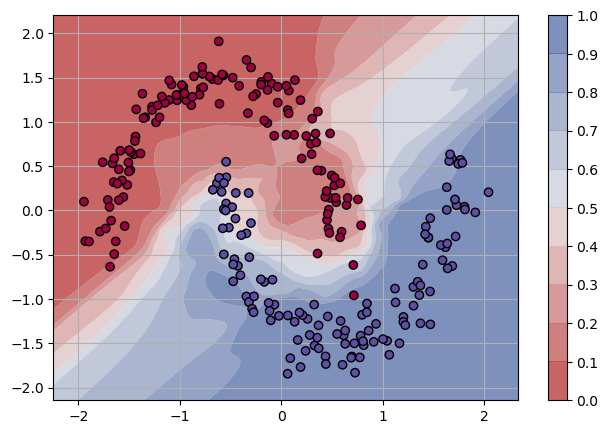

In [7]:
### CREATE A MESHGRID ###
# Create a meshgrid for the whole dataset such that we can plot the predictions for each point
h = .01  # step size in the mesh
buffer = 0.3 # buffer for the axes
x_min, x_max = X[:, 0].min() - buffer, X[:, 0].max() + buffer # min and max of the first feature
y_min, y_max = X[:, 1].min() - buffer, X[:, 1].max() + buffer # min and max of the second feature
xx,yy= np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
grid = np.c_[xx.ravel(), yy.ravel()]
grid = torch.from_numpy((grid - X.mean(axis=0)) / X.std(axis=0)).float().to(DEVICE)
# mincol in red hexa code, axcol in blue hexa code
custom_map = custom_div_cmap(
    11, mincol='#B22222', midcol='0.9', maxcol='#4863A0')

### SEED ###
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

### PREDICT ###
N_TEST_SAMPLES = 10
clevels = 9
Z = network.predict(grid, N_TEST_SAMPLES) 
Z = torch.stack(Z, dim=0)
Z = Z.mean(dim=0)
# Depending on the loss function, we need to apply an activation function to the output
if "binary_cross_entropy" in network_data["criterion"].__name__:
    Z = Z.cpu().reshape(xx.shape)
else:
    Z = torch.exp(Z)
    Z = torch.max(Z, dim=1)[0].reshape(xx.shape).cpu()

### PLOT ###
# Plot the predictions with the uncertainty
fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))
ax.grid(True)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Spectral, edgecolors='k', zorder=2)

# Plot the uncertainty with contourf based on the value of Z
c = ax.contourf(xx, yy, Z, alpha=0.7, levels=clevels, antialiased=True, cmap=custom_map, zorder=1)

# Add a colorbar
colorbar = fig.colorbar(c, ax=ax, ticks=np.arange(0, 1.1, 1 / (clevels+1)))
# force the leftbar to be between 0 and 1
c.get_clim()
c.set_clim(0, 1)
colorbar.ax.set_ylim(0, 1)

os.makedirs(SAVE_FOLDER, exist_ok=True)
plt.savefig(os.path.join(SAVE_FOLDER, "two-moons-uncertainty-DNN-mean.pdf"), bbox_inches='tight')
plt.show()


In [8]:

### NETWORK CONFIGURATION ###
network_data = {
    "nn_type": models.DNN,
    "nn_parameters": {
        "layers": [INPUT_SIZE] + LAYER_SIZE + [OUT],
        "device": DEVICE,
        "dropout": False, # Dropout layers
        "batchnorm": False, # Batch normalization layers
        "bias": True,
        "latent_weights": False, # Latent weights for BiNN
        "output_function": OUTPUT_FUNCTION, # Activation function for output layer (as loss function is BCE_with_logits, no activation function is needed)
        "activation_function": torch.functional.F.relu, # Activation function for hidden layers
    },
    "training_parameters": {
        'n_epochs': EPOCHS,
        'batch_size': BATCH_SIZE,
        'test_mcmc_samples': 1,
    },
    "criterion": CRITERION,
    "optimizer": BayesBiNN,
    "optimizer_parameters": {
        "temperature": 1,
        "num_mcmc_samples": 0,
        "init_lambda": 5,
        "lr": LEARNING_RATE,
        "beta": 0.99
    },
}

train_tensor = GPUTensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
test_tensor = GPUTensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

if "binary_cross_entropy" in network_data["criterion"].__name__:
    train_tensor.targets = train_tensor.targets.float().unsqueeze(1)
    test_tensor.targets = test_tensor.targets.float().unsqueeze(1)

train_loader = GPUDataLoader(train_tensor, batch_size=network_data["training_parameters"]["batch_size"], shuffle=True)
test_loader = GPUDataLoader(test_tensor, batch_size=te_size, shuffle=False)

### SEED ###
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

### ACCURACY INITIALIZATION ###
accuracies = []
batch_size = network_data['training_parameters']['batch_size']

### NETWORK INITIALIZATION ###
model = network_data['nn_type'](**network_data['nn_parameters'])

### INSTANTIATE THE TRAINER ###
network = trainer.BayesTrainer(batch_size=batch_size,
                                model=model, **network_data, device=DEVICE)
### TRAINING ###
network.fit(
    train_loader, 
    **network_data['training_parameters'], 
    test_loader=[test_loader, train_loader],
    name_loader=["Test accuracy", "Train accuracy"]
)

Epoch 33/3000:   1%|          | 32/3000 [00:00<00:18, 158.00it/s, loss=10.1]

Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 62.00%
Testing accuracy: 
	Test accuracy: 42.00%
	Train accuracy: 62.40%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 40.00%
	Train accuracy: 47.60%
Testing accuracy: 
	Test accuracy: 22.00%
	Train accuracy: 69.20%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 62.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 49.60%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 36.40%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 20.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 52.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 71.20%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 66.80%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 80.40%
Testing ac

Epoch 60/3000:   2%|▏         | 48/3000 [00:00<00:20, 146.77it/s, loss=9.3] 

	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 50.40%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 56.00%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 59.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 76.00%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 68.40%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 75.60%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 65.20%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 44.00%
	Train acc

Epoch 86/3000:   3%|▎         | 78/3000 [00:00<00:21, 133.62it/s, loss=7.66]

	Test accuracy: 82.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 81.60%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 68.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 28.00%
	Train accuracy: 56.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 50.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 78.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 72.80%
Testing accuracy: 
	Test accuracy: 54.00%
	Train accuracy: 81.60%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 27.20%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 70.00%
Testing accuracy: 
	Test accu

Epoch 116/3000:   4%|▎         | 108/3000 [00:00<00:20, 140.31it/s, loss=5.06]

Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 60.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 71.20%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 62.40%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 72.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 76.40%
Testing accuracy: 
	Test accuracy: 42.00%
	Train accuracy: 74.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 58.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing ac

Epoch 145/3000:   5%|▍         | 140/3000 [00:01<00:19, 143.66it/s, loss=4.81]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 76.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 42.00%
	Train accuracy: 77.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 74.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 57.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 68.40%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 52.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 64.40%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 72.80%
Testing ac

Epoch 176/3000:   6%|▌         | 173/3000 [00:01<00:19, 146.76it/s, loss=4.3] 

Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 80.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 44.00%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 71.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 72.40%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 60.80%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 69.60%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 64.80%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 58.00%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 74.00%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 78.80%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 76.80%
Testing ac

Epoch 209/3000:   7%|▋         | 207/3000 [00:01<00:17, 155.58it/s, loss=3.09]

	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 64.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 52.40%
Testing accuracy: 
	Test accuracy: 50.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 75.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 67.20%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 78.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 55.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 66.40%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 66.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 54.00%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 64.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train acc

Epoch 240/3000:   7%|▋         | 223/3000 [00:01<00:18, 150.27it/s, loss=2.96]

	Test accuracy: 62.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 78.80%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 62.40%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 75.60%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 73.20%
Testing accuracy: 
	Test accu

Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 64.80%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 72.80%
Testing accuracy: 
	Test accuracy: 50.00%
	Train accuracy: 58.80%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 62.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 32.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 75.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 74.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 50.00%
	Train accuracy: 55.20%
Testing accuracy: 
	Test accuracy: 36.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 63.60%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 67.20%
Testing ac

Epoch 300/3000:  10%|▉         | 290/3000 [00:02<00:17, 152.61it/s, loss=1.45]

Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 80.80%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 78.40%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 76.40%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 81.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 20.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 74.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 63.60%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 78.80%
Testing accuracy: 
	Test accuracy: 48.00%
	Train accuracy: 20.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 78.80%
Testing ac

Epoch 332/3000:  11%|█         | 323/3000 [00:02<00:17, 155.31it/s, loss=1.34]

Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 62.00%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 76.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 78.80%
Testing accuracy: 
	Test accuracy: 54.00%
	Train accuracy: 80.80%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 58.40%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 70.80%
Testing accuracy: 
	Test accuracy: 54.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 77.20%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 80.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 52.40%
Testing ac

Epoch 365/3000:  12%|█▏        | 357/3000 [00:02<00:16, 159.38it/s, loss=1.27]

Testing accuracy: 
	Test accuracy: 50.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 72.80%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 76.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 68.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 65.20%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 77.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 60.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 63.20%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 73.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 73.20%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 78.40%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 76.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 49.20%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 76.40%
Testing ac

Epoch 397/3000:  13%|█▎        | 390/3000 [00:02<00:16, 159.95it/s, loss=0.913]

	Test accuracy: 86.00%
	Train accuracy: 73.20%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 72.40%
Testing accuracy: 
	Test accuracy: 34.00%
	Train accuracy: 71.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 61.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 55.60%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 48.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 74.40%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 81.60%
Testing accuracy: 
	Test accuracy: 50.00%
	Train accuracy: 50.40%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 73.60%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 54.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 76.80%
Testing accuracy: 
	Test accu

Epoch 425/3000:  14%|█▍        | 423/3000 [00:02<00:17, 149.30it/s, loss=0.896]

Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 72.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 44.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 58.80%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 29.60%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 58.80%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 76.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 79.20%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 76.40%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 56.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 78.40%
Testing ac

Epoch 459/3000:  15%|█▌        | 458/3000 [00:03<00:16, 157.96it/s, loss=0.53] 

Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 64.40%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 52.80%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 66.40%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 54.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 60.40%
Testing accuracy: 
	Test accuracy: 54.00%
	Train accuracy: 74.00%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 46.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 67.60%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 81.20%
Testing ac

Epoch 490/3000:  16%|█▌        | 474/3000 [00:03<00:16, 153.10it/s, loss=0.498]

Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 77.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 50.00%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 53.60%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 38.80%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 54.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 21.60%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 48.80%
Testing ac

Epoch 523/3000:  17%|█▋        | 507/3000 [00:03<00:15, 156.91it/s, loss=0.464]

Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 81.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 50.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 79.20%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 54.80%
Testing accuracy: 
	Test accuracy: 38.00%
	Train accuracy: 57.20%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 68.40%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 62.80%
Testing accuracy: 
	Test accuracy: 54.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 48.00%
	Train accuracy: 74.40%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 80.40%
Testing ac

Epoch 551/3000:  18%|█▊        | 542/3000 [00:03<00:16, 151.34it/s, loss=0.437]

Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 63.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 42.00%
	Train accuracy: 49.20%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 59.20%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 68.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 60.40%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 32.40%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 74.80%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 31.20%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 48.80%
Testing ac

Epoch 581/3000:  19%|█▉        | 574/3000 [00:03<00:16, 151.11it/s, loss=0.0834]

Testing accuracy: 
	Test accuracy: 34.00%
	Train accuracy: 62.80%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 38.00%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 54.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 64.40%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 68.80%
Testing accuracy: 
	Test accuracy: 48.00%
	Train accuracy: 54.40%
Testing accuracy: 
	Test accuracy: 46.00%
	Train accuracy: 60.80%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 72.80%
Testing accuracy: 
	Test accuracy: 22.00%
	Train accuracy: 75.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 49.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 46.80%
Testing accuracy: 
	Test accuracy: 38.00%
	Train accuracy: 74.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 62.00%
Testing ac

Epoch 612/3000:  20%|██        | 606/3000 [00:04<00:15, 151.78it/s, loss=0.0714]

	Test accuracy: 38.00%
	Train accuracy: 55.60%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 68.80%
Testing accuracy: 
	Test accuracy: 24.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 33.60%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 72.40%
Testing accuracy: 
	Test accuracy: 34.00%
	Train accuracy: 20.80%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 63.20%
Testing accuracy: 
	Test accuracy: 16.00%
	Train accuracy: 57.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 24.00%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 38.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 74.80%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 67.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 70.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 55.20%
Testing accuracy: 
	Test accu

Epoch 640/3000:  21%|██▏       | 639/3000 [00:04<00:16, 146.18it/s, loss=0.0589]

Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 57.60%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 65.60%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 61.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 34.80%
Testing accuracy: 
	Test accuracy: 50.00%
	Train accuracy: 68.80%
Testing accuracy: 
	Test accuracy: 18.00%
	Train accuracy: 42.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 26.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 75.20%
Testing accuracy: 
	Test accuracy: 24.00%
	Train accuracy: 60.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 58.80%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 74.80%
Testing ac

Epoch 673/3000:  22%|██▏       | 671/3000 [00:04<00:15, 151.06it/s, loss=0.0477]

Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 67.60%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 59.20%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 58.80%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 76.40%
Testing accuracy: 
	Test accuracy: 54.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 79.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 52.40%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 64.80%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 54.80%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 49.60%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 30.80%
Testing accuracy: 
	Test accuracy: 48.00%
	Train accuracy: 81.60%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 66.80%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 48.00%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 76.40%
Testing ac

Epoch 704/3000:  23%|██▎       | 687/3000 [00:04<00:15, 149.78it/s, loss=0.0398]

Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 81.20%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 46.40%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 57.20%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 74.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 59.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 75.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 61.60%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 38.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 54.00%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 72.80%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 62.00%
Testing ac

Epoch 732/3000:  24%|██▍       | 720/3000 [00:04<00:15, 149.92it/s, loss=0.0362]

	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 63.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 28.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 68.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 52.00%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 54.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.80%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 53.60%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 40.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 62.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 76.00%
Testing accuracy: 
	Test accuracy: 30.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 38.00%
	Train accuracy: 63.20%
Testing accuracy: 
	Test accuracy: 74.00%
	Train acc

Epoch 760/3000:  25%|██▌       | 752/3000 [00:05<00:14, 150.88it/s, loss=0.031] 

Testing accuracy: 
	Test accuracy: 34.00%
	Train accuracy: 68.80%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 64.00%
Testing accuracy: 
	Test accuracy: 22.00%
	Train accuracy: 72.00%
Testing accuracy: 
	Test accuracy: 28.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 46.80%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 80.80%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 60.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 50.40%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 58.00%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 48.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 74.00%
Testing ac

Epoch 785/3000:  26%|██▌       | 782/3000 [00:05<00:16, 133.17it/s, loss=0.0273]

Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 55.20%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 58.40%
Testing accuracy: 
	Test accuracy: 34.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 30.40%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 76.40%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 32.00%
	Train accuracy: 81.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 49.20%
Testing accuracy: 
	Test accuracy: 46.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 72.00%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 89.20%
Testing ac

Epoch 816/3000:  27%|██▋       | 812/3000 [00:05<00:15, 140.34it/s, loss=0.0217]

Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 64.80%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 72.00%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 50.00%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 23.60%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 77.20%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 64.80%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 65.20%
Testing ac

Epoch 847/3000:  28%|██▊       | 845/3000 [00:05<00:14, 149.73it/s, loss=0.0172]

	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 35.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 52.40%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 46.00%
	Train accuracy: 65.20%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 27.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 64.00%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 57.60%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 64.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 57.60%
Testing accuracy: 
	Test accuracy: 50.00%
	Train accuracy: 72.40%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 47.60%
Testing accuracy: 
	Test accuracy: 26.00%
	Train accuracy: 50.00%
Testing accuracy: 
	Test accuracy: 42.00%
	Train acc

Epoch 875/3000:  29%|██▊       | 861/3000 [00:05<00:14, 147.82it/s, loss=0.0131]

	Train accuracy: 58.00%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 66.40%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 53.60%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 76.80%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 42.00%
	Train accuracy: 69.20%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 58.80%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 50.40%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 62.00%
	Train acc

Epoch 899/3000:  30%|██▉       | 891/3000 [00:06<00:15, 134.96it/s, loss=0.0106]

Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 65.60%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 64.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 77.20%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 65.20%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 53.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 76.80%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 62.80%
Testing accuracy: 
	Test accuracy: 30.00%
	Train accuracy: 32.00%
Testing accuracy: 
	Test accuracy: 38.00%
	Train accuracy: 64.80%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 22.00%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 48.40%
Testing ac

Testing accuracy: 
	Test accuracy: 38.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 54.40%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 62.40%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 53.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 74.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 69.20%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 47.20%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 70.00%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 55.20%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 74.00%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 70.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 57.20%
Testing ac

Epoch 963/3000:  32%|███▏      | 955/3000 [00:06<00:13, 152.19it/s, loss=0.00615]

	Test accuracy: 86.00%
	Train accuracy: 74.40%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 76.00%
Testing accuracy: 
	Test accuracy: 32.00%
	Train accuracy: 54.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 60.00%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 22.00%
Testing accuracy: 
	Test accuracy: 24.00%
	Train accuracy: 78.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 35.20%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 64.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 71.60%
Testing accuracy: 
	Test accuracy: 32.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accu

Epoch 994/3000:  33%|███▎      | 987/3000 [00:06<00:13, 149.20it/s, loss=0.00495]

Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 57.20%
Testing accuracy: 
	Test accuracy: 30.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 48.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 73.60%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 56.00%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 60.00%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 67.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 58.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 63.20%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 57.60%
Testing accuracy: 
	Test accuracy: 36.00%
	Train accuracy: 63.20%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 88.80%
Testing ac

Epoch 1027/3000:  34%|███▍      | 1022/3000 [00:06<00:12, 158.46it/s, loss=0.0043] 

Testing accuracy: 
	Test accuracy: 46.00%
	Train accuracy: 58.00%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 75.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 49.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 20.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 20.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 50.40%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 56.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 67.20%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 45.60%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 65.20%
Testing accuracy: 
	Test accuracy: 46.00%
	Train accuracy: 43.20%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 51.20%
Testing ac

Epoch 1061/3000:  35%|███▌      | 1056/3000 [00:07<00:11, 164.31it/s, loss=0.00397]

Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 56.00%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 50.00%
	Train accuracy: 53.60%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 75.60%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 35.60%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 81.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 38.40%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 72.80%
Testing accuracy: 
	Test accuracy: 46.00%
	Train accuracy: 74.00%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 77.20%
Testing accuracy: 
	Test accuracy: 24.00%
	Train accuracy: 65.20%
Testing accuracy: 
	Test accuracy: 16.00%
	Train accuracy: 84.00%
Testing ac

Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 69.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 37.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 56.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 81.20%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 24.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 62.80%
Testing accuracy: 
	Test accuracy: 50.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 60.80%
Testing accuracy: 
	Test accuracy: 42.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 72.40%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 55.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 66.40%
Testing accuracy: 
	Test accuracy: 22.00%
	Train accuracy: 29.60%
Testing ac

Epoch 1121/3000:  37%|███▋      | 1107/3000 [00:07<00:11, 158.64it/s, loss=0.0038] 

Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 58.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 69.60%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 49.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 78.80%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 55.20%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 50.40%
Testing accuracy: 
	Test accuracy: 26.00%
	Train accuracy: 78.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 38.80%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 81.60%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 86.40%
Testing ac

Epoch 1152/3000:  38%|███▊      | 1139/3000 [00:07<00:12, 151.87it/s, loss=0.00363]

Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 58.80%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 79.20%
Testing accuracy: 
	Test accuracy: 28.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 75.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 57.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 60.40%
Testing accuracy: 
	Test accuracy: 54.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 79.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 54.40%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 48.40%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 54.80%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 78.40%
Testing accuracy: 
	Test accuracy: 36.00%
	Train accuracy: 76.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 72.00%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 88.40%
Testing ac

Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 79.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 79.20%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 48.40%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 41.60%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 41.60%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 34.80%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 62.00%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 18.80%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 55.60%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 77.20%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 43.20%
Testing ac

Epoch 1213/3000:  40%|████      | 1204/3000 [00:08<00:11, 155.01it/s, loss=0.00353]

	Train accuracy: 49.60%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 42.40%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 27.20%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 24.80%
Testing accuracy: 
	Test accuracy: 32.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 77.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 46.00%
	Train accuracy: 72.00%
Testing accuracy: 
	Test accuracy: 46.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 60.00%
Testing accuracy: 
	Test accuracy: 48.00%
	Train acc

Epoch 1243/3000:  41%|████      | 1236/3000 [00:08<00:11, 150.18it/s, loss=0.00349]

Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 52.00%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 22.00%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 81.60%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 56.80%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 36.00%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 67.20%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 79.20%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 36.40%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 54.80%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 44.80%
Testing ac

Epoch 1276/3000:  42%|████▏     | 1269/3000 [00:08<00:11, 156.66it/s, loss=0.00344]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 42.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 56.40%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 57.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 42.00%
	Train accuracy: 23.60%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 62.40%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 55.60%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 22.00%
	Train accuracy: 76.40%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 52.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 60.40%
Testing ac

Epoch 1307/3000:  43%|████▎     | 1301/3000 [00:08<00:11, 153.81it/s, loss=0.00341]

Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 30.40%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 53.60%
Testing accuracy: 
	Test accuracy: 50.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 18.00%
	Train accuracy: 42.80%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 74.40%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 22.40%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 76.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 53.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 50.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 75.60%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 50.00%
Testing ac

Epoch 1336/3000:  44%|████▍     | 1333/3000 [00:08<00:10, 151.70it/s, loss=0.00338]

Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 58.00%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 54.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 47.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 54.00%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 44.40%
Testing accuracy: 
	Test accuracy: 42.00%
	Train accuracy: 76.80%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 46.00%
	Train accuracy: 55.60%
Testing accuracy: 
	Test accuracy: 30.00%
	Train accuracy: 78.40%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 54.00%
Testing accuracy: 
	Test accuracy: 42.00%
	Train accuracy: 78.80%
Testing accuracy: 
	Test accuracy: 50.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 79.20%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 59.20%
Testing ac

Epoch 1367/3000:  46%|████▌     | 1366/3000 [00:09<00:10, 152.70it/s, loss=0.00335]

Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 56.80%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 74.40%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 74.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 65.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 23.20%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 72.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 72.40%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 67.20%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 77.20%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 82.40%
Testing ac

Epoch 1397/3000:  46%|████▌     | 1382/3000 [00:09<00:10, 148.88it/s, loss=0.00332]

Testing accuracy: 
	Test accuracy: 48.00%
	Train accuracy: 66.00%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 52.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 70.80%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 42.00%
Testing accuracy: 
	Test accuracy: 50.00%
	Train accuracy: 73.60%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 66.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 30.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 74.80%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 46.80%
Testing ac

Epoch 1427/3000:  47%|████▋     | 1414/3000 [00:09<00:10, 152.32it/s, loss=0.00329]

Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 38.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 71.60%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 66.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 76.80%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 34.00%
	Train accuracy: 20.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 54.00%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 50.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 47.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 32.40%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 53.20%
Testing accuracy: 
	Test accuracy: 36.00%
	Train accuracy: 48.80%
Testing ac

Epoch 1453/3000:  48%|████▊     | 1445/3000 [00:09<00:10, 143.46it/s, loss=0.00327]

Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 38.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 66.40%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 46.40%
Testing accuracy: 
	Test accuracy: 54.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 46.00%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 36.00%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 66.40%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 76.40%
Testing accuracy: 
	Test accuracy: 48.00%
	Train accuracy: 47.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 51.60%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 21.20%
Testing ac

Epoch 1482/3000:  49%|████▉     | 1475/3000 [00:09<00:10, 139.94it/s, loss=0.00325]

Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 66.00%
Testing accuracy: 
	Test accuracy: 50.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 47.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 62.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 57.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 19.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 60.00%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 46.40%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 76.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 60.00%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 52.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 50.00%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 72.80%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 43.20%
Testing ac

Epoch 1512/3000:  50%|█████     | 1506/3000 [00:10<00:10, 144.46it/s, loss=0.00323]

Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 74.00%
Testing accuracy: 
	Test accuracy: 48.00%
	Train accuracy: 63.20%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 71.20%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 71.20%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 64.80%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 76.80%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 50.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 61.20%
Testing accuracy: 
	Test accuracy: 54.00%
	Train accuracy: 79.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 64.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 80.00%
Testing ac

Epoch 1542/3000:  51%|█████     | 1536/3000 [00:10<00:10, 145.76it/s, loss=0.0032] 

	Train accuracy: 81.20%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 73.60%
Testing accuracy: 
	Test accuracy: 50.00%
	Train accuracy: 56.80%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 61.20%
Testing accuracy: 
	Test accuracy: 38.00%
	Train accuracy: 76.80%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 54.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 76.40%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 80.80%
Testing accuracy: 
	Test accuracy: 28.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 74.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 75.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 76.00%
	Train acc

Epoch 1574/3000:  52%|█████▏    | 1568/3000 [00:10<00:09, 150.25it/s, loss=0.00318]

	Test accuracy: 52.00%
	Train accuracy: 68.40%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 54.80%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 61.20%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 53.20%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 79.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 31.60%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 30.40%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 68.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 46.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 65.20%
Testing accuracy: 
	Test accu

Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 69.60%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 76.80%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 54.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 75.60%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 73.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 74.40%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 48.00%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 74.00%
Testing accuracy: 
	Test accuracy: 36.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 40.00%
	Train accuracy: 64.00%
Testing ac

Epoch 1635/3000:  54%|█████▍    | 1633/3000 [00:10<00:08, 155.10it/s, loss=0.00314]

	Test accuracy: 58.00%
	Train accuracy: 67.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 54.40%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 66.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 54.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 62.80%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 72.80%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 56.40%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 29.20%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 64.00%
Testing accuracy: 
	Test accu

Epoch 1662/3000:  55%|█████▍    | 1649/3000 [00:11<00:08, 150.44it/s, loss=0.00312]

Testing accuracy: 
	Test accuracy: 48.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 48.00%
	Train accuracy: 52.00%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 44.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 81.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 67.20%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 75.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 46.00%
	Train accuracy: 39.60%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 70.00%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 28.40%
Testing accuracy: 
	Test accuracy: 48.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 48.80%
Testing ac

Epoch 1688/3000:  56%|█████▌    | 1680/3000 [00:11<00:09, 138.73it/s, loss=0.0031] 

Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 24.80%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 45.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 59.20%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 63.20%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 46.00%
	Train accuracy: 66.40%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 49.60%
Testing accuracy: 
	Test accuracy: 48.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 49.60%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 60.80%
Testing accuracy: 
	Test accuracy: 40.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 57.60%
Testing accuracy: 
	Test accuracy: 50.00%
	Train accuracy: 78.40%
Testing ac

Epoch 1717/3000:  57%|█████▋    | 1709/3000 [00:11<00:09, 137.41it/s, loss=0.00309]

Testing accuracy: 
	Test accuracy: 50.00%
	Train accuracy: 68.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 69.60%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 77.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 65.60%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 71.60%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 58.40%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 76.40%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 87.60%
Testing ac

Epoch 1745/3000:  58%|█████▊    | 1739/3000 [00:11<00:09, 139.17it/s, loss=0.00307]

Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 48.00%
Testing accuracy: 
	Test accuracy: 48.00%
	Train accuracy: 80.80%
Testing accuracy: 
	Test accuracy: 40.00%
	Train accuracy: 37.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 43.60%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 57.20%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 38.40%
Testing accuracy: 
	Test accuracy: 46.00%
	Train accuracy: 62.40%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 57.60%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 74.80%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 50.80%
Testing ac

Epoch 1770/3000:  59%|█████▉    | 1767/3000 [00:11<00:09, 131.40it/s, loss=0.00305]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 48.40%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 53.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 74.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 58.40%
Testing accuracy: 
	Test accuracy: 46.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 66.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 47.20%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 52.00%
Testing ac

Epoch 1799/3000:  60%|█████▉    | 1797/3000 [00:12<00:08, 136.98it/s, loss=0.00304]

Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 58.80%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 81.60%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 56.40%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 59.60%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 59.20%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 30.00%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 22.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 46.80%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 72.80%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 51.20%
Testing ac

Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 32.00%
	Train accuracy: 74.80%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 16.40%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 78.40%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 48.00%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 54.80%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 63.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 81.60%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 52.00%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 66.80%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 60.40%
Testing accuracy: 
	Test accuracy: 50.00%
	Train accuracy: 81.20%
Testing ac

Epoch 1855/3000:  62%|██████▏   | 1855/3000 [00:12<00:08, 141.15it/s, loss=0.00301]

Testing accuracy: 
	Test accuracy: 38.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 74.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 50.40%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 42.80%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 21.60%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 28.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 54.00%
	Train accuracy: 21.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 66.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 58.00%
Testing ac

Epoch 1885/3000:  62%|██████▏   | 1870/3000 [00:12<00:07, 142.90it/s, loss=0.00299]

Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 78.40%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 37.60%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 48.00%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 15.60%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 52.80%
Testing accuracy: 
	Test accuracy: 54.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 61.20%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 31.60%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 36.40%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 74.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 50.00%
	Train accuracy: 66.80%
Testing ac

Epoch 1913/3000:  63%|██████▎   | 1900/3000 [00:12<00:07, 140.87it/s, loss=0.00298]

Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 30.00%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 76.00%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 32.00%
Testing accuracy: 
	Test accuracy: 46.00%
	Train accuracy: 38.00%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 35.60%
Testing accuracy: 
	Test accuracy: 6.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 36.00%
	Train accuracy: 64.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 76.40%
Testing accuracy: 
	Test accuracy: 24.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 59.20%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 52.40%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 58.80%
Testing accuracy: 
	Test accuracy: 54.00%
	Train accuracy: 51.20%
Testing acc

Testing accuracy: 
	Test accuracy: 32.00%
	Train accuracy: 53.60%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 76.80%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 56.00%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 36.00%
	Train accuracy: 58.40%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 64.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 60.00%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 56.80%
Testing accuracy: 
	Test accuracy: 42.00%
	Train accuracy: 66.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 59.20%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 28.40%
Testing accuracy: 
	Test accuracy: 42.00%
	Train accuracy: 30.80%
Testing ac

Epoch 1971/3000:  65%|██████▌   | 1961/3000 [00:13<00:07, 145.58it/s, loss=0.00295]

	Test accuracy: 54.00%
	Train accuracy: 31.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 72.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 45.60%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 54.40%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 61.60%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 50.00%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 66.40%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 54.00%
	Train accuracy: 56.80%
Testing accuracy: 
	Test accuracy: 42.00%
	Train accuracy: 60.80%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 22.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 55.60%
Testing accuracy: 
	Test accu

Epoch 1998/3000:  66%|██████▋   | 1993/3000 [00:13<00:06, 149.74it/s, loss=0.00293]

Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 73.60%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 41.20%
Testing accuracy: 
	Test accuracy: 34.00%
	Train accuracy: 63.20%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 66.80%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 57.60%
Testing accuracy: 
	Test accuracy: 26.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 68.40%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 41.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 48.40%
Testing ac

Epoch 2026/3000:  67%|██████▋   | 2024/3000 [00:13<00:07, 136.87it/s, loss=0.00292]

Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 28.80%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 73.60%
Testing accuracy: 
	Test accuracy: 50.00%
	Train accuracy: 47.20%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 81.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 32.80%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 78.40%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 38.40%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 47.60%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 81.20%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 80.80%
Testing accuracy: 
	Test accuracy: 30.00%
	Train accuracy: 86.40%
Testing ac

Epoch 2055/3000:  68%|██████▊   | 2053/3000 [00:13<00:06, 136.02it/s, loss=0.00291]

Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 64.40%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 32.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 71.60%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 34.40%
Testing accuracy: 
	Test accuracy: 40.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 78.80%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 78.40%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 68.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 61.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 53.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 85.20%
Testing ac

Epoch 2083/3000:  69%|██████▉   | 2083/3000 [00:14<00:06, 139.48it/s, loss=0.00289]

Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 64.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 40.00%
	Train accuracy: 55.20%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 63.20%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 59.60%
Testing accuracy: 
	Test accuracy: 40.00%
	Train accuracy: 67.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 38.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 42.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 79.20%
Testing ac

Epoch 2110/3000:  70%|██████▉   | 2098/3000 [00:14<00:06, 134.16it/s, loss=0.00288]

Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 54.00%
	Train accuracy: 72.00%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 72.80%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 62.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 48.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 36.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 72.80%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 73.20%
Testing accuracy: 
	Test accuracy: 46.00%
	Train accuracy: 60.40%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 47.20%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 53.20%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 14.00%
Testing ac

Epoch 2142/3000:  71%|███████   | 2130/3000 [00:14<00:06, 144.38it/s, loss=0.00287]

	Test accuracy: 68.00%
	Train accuracy: 40.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 76.40%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 48.00%
	Train accuracy: 46.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 65.60%
Testing accuracy: 
	Test accuracy: 32.00%
	Train accuracy: 30.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 60.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 76.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 38.00%
Testing accuracy: 
	Test accuracy: 38.00%
	Train accuracy: 81.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 62.00%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 28.00%
	Train accuracy: 54.40%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 78.40%
Testing accuracy: 
	Test accu

Epoch 2174/3000:  72%|███████▏  | 2164/3000 [00:14<00:05, 153.95it/s, loss=0.00285]

Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 60.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 74.80%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 63.20%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 61.60%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 33.20%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 40.00%
	Train accuracy: 63.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 80.80%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 36.40%
Testing accuracy: 
	Test accuracy: 50.00%
	Train accuracy: 64.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 59.20%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 48.80%
Testing ac

Epoch 2204/3000:  73%|███████▎  | 2196/3000 [00:14<00:05, 151.04it/s, loss=0.00284]

Testing accuracy: 
	Test accuracy: 38.00%
	Train accuracy: 49.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 79.20%
Testing accuracy: 
	Test accuracy: 32.00%
	Train accuracy: 46.80%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 81.20%
Testing accuracy: 
	Test accuracy: 12.00%
	Train accuracy: 55.60%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 56.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 33.60%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 53.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 66.40%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 23.20%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 42.80%
Testing accuracy: 
	Test accuracy: 38.00%
	Train accuracy: 62.80%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 63.20%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 66.40%
Testing accuracy: 
	Test accuracy: 20.00%
	Train accuracy: 33.20%
Testing ac

Epoch 2234/3000:  74%|███████▍  | 2227/3000 [00:15<00:05, 147.00it/s, loss=0.00283]

Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 55.60%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 31.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 40.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 54.00%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 74.00%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 52.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.00%
Testing ac

Epoch 2249/3000:  75%|███████▍  | 2242/3000 [00:15<00:05, 144.88it/s, loss=0.00282]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 60.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 50.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 36.00%
	Train accuracy: 56.00%
Testing accuracy: 
	Test accuracy: 54.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 69.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 47.60%
Testing accuracy: 
	Test accuracy: 54.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 49.20%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 63.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 50.00%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 78.00%
Testing ac

	Test accuracy: 66.00%
	Train accuracy: 73.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 54.40%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 22.80%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 53.60%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 59.60%
Testing accuracy: 
	Test accuracy: 40.00%
	Train accuracy: 60.80%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 67.60%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 54.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 63.20%
Testing accuracy: 
	Test accuracy: 48.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 76.00%
Testing accuracy: 
	Test accuracy: 36.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accu

Epoch 2303/3000:  77%|███████▋  | 2296/3000 [00:15<00:05, 135.10it/s, loss=0.0028] 

Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 38.00%
	Train accuracy: 54.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 59.60%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 81.20%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 58.40%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 71.60%
Testing accuracy: 
	Test accuracy: 48.00%
	Train accuracy: 58.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 52.40%
Testing accuracy: 
	Test accuracy: 50.00%
	Train accuracy: 65.20%
Testing accuracy: 
	Test accuracy: 42.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 28.00%
	Train accuracy: 45.20%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 54.80%
Testing accuracy: 
	Test accuracy: 14.00%
	Train accuracy: 54.40%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 72.80%
Testing ac

Epoch 2333/3000:  78%|███████▊  | 2327/3000 [00:15<00:04, 135.26it/s, loss=0.00279]

Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 58.80%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 52.80%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 56.00%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 79.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 55.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 62.80%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 72.40%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 70.80%
Testing accuracy: 
	Test accuracy: 36.00%
	Train accuracy: 69.60%
Testing accuracy: 
	Test accuracy: 36.00%
	Train accuracy: 49.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 81.20%
Testing ac

	Train accuracy: 76.40%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 48.40%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 47.60%
Testing accuracy: 
	Test accuracy: 48.00%
	Train accuracy: 23.20%
Testing accuracy: 
	Test accuracy: 46.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 60.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 57.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 39.60%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 38.80%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 76.40%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 47.60%
Testing accuracy: 
	Test accuracy: 66.00%
	Train acc

Epoch 2393/3000:  80%|███████▉  | 2390/3000 [00:16<00:04, 148.93it/s, loss=0.00276]

	Test accuracy: 44.00%
	Train accuracy: 80.80%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 75.20%
Testing accuracy: 
	Test accuracy: 20.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 56.00%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 42.00%
	Train accuracy: 40.00%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 62.00%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 53.60%
Testing accuracy: 
	Test accuracy: 20.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 38.00%
	Train accuracy: 59.20%
Testing accuracy: 
	Test accuracy: 54.00%
	Train accuracy: 48.40%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 58.00%
Testing accuracy: 
	Test accu

Epoch 2423/3000:  81%|████████  | 2422/3000 [00:16<00:03, 150.08it/s, loss=0.00275]

	Test accuracy: 44.00%
	Train accuracy: 81.20%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 45.60%
Testing accuracy: 
	Test accuracy: 48.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 41.20%
Testing accuracy: 
	Test accuracy: 28.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 56.40%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 46.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 76.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 68.80%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 48.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accu

Epoch 2452/3000:  81%|████████▏ | 2439/3000 [00:16<00:03, 153.71it/s, loss=0.00274]

Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 70.80%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 73.60%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 47.60%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 25.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 77.20%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 47.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 72.40%
Testing accuracy: 
	Test accuracy: 50.00%
	Train accuracy: 76.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 72.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 78.40%
Testing ac

Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 60.80%
Testing accuracy: 
	Test accuracy: 34.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 52.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 31.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 32.80%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 75.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 75.60%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 74.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 22.80%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 60.00%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 87.60%
Testing ac

Epoch 2509/3000:  83%|████████▎ | 2500/3000 [00:17<00:03, 141.37it/s, loss=0.00272]

Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 53.60%
Testing accuracy: 
	Test accuracy: 24.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 56.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 57.20%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 32.00%
	Train accuracy: 26.40%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 78.80%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 80.80%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 65.20%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 57.60%
Testing ac

Epoch 2539/3000:  84%|████████▍ | 2530/3000 [00:17<00:03, 142.08it/s, loss=0.00271]

Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 31.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 52.40%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 79.20%
Testing accuracy: 
	Test accuracy: 54.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 73.60%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 57.60%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 34.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 57.60%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 64.00%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 82.80%
Testing ac

Epoch 2568/3000:  85%|████████▌ | 2562/3000 [00:17<00:03, 144.76it/s, loss=0.0027] 

Testing accuracy: 
	Test accuracy: 40.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 50.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 57.20%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 81.20%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 56.80%
Testing accuracy: 
	Test accuracy: 48.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 58.00%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 54.00%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 54.00%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 36.00%
Testing ac

Epoch 2601/3000:  86%|████████▋ | 2594/3000 [00:17<00:02, 150.41it/s, loss=0.00268]

Testing accuracy: 
	Test accuracy: 18.00%
	Train accuracy: 77.20%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 54.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 23.60%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 46.80%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 56.80%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 22.00%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 39.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 82.00%
Testing ac

Epoch 2631/3000:  88%|████████▊ | 2627/3000 [00:17<00:02, 151.80it/s, loss=0.00267]

	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 75.60%
Testing accuracy: 
	Test accuracy: 26.00%
	Train accuracy: 76.80%
Testing accuracy: 
	Test accuracy: 30.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 54.00%
	Train accuracy: 62.80%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 60.40%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 49.20%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 50.80%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 70.00%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 70.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train acc

Epoch 2662/3000:  89%|████████▊ | 2660/3000 [00:18<00:02, 154.04it/s, loss=0.00266]

	Test accuracy: 24.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 56.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 68.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 74.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 53.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 58.00%
Testing accuracy: 
	Test accuracy: 24.00%
	Train accuracy: 66.40%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 33.60%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 34.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 40.40%
Testing accuracy: 
	Test accu

Epoch 2692/3000:  90%|████████▉ | 2692/3000 [00:18<00:02, 153.94it/s, loss=0.00265]

	Test accuracy: 62.00%
	Train accuracy: 41.20%
Testing accuracy: 
	Test accuracy: 40.00%
	Train accuracy: 64.00%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 70.80%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 50.00%
	Train accuracy: 52.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 48.00%
	Train accuracy: 65.20%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 60.00%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 52.00%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 81.20%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accu

Epoch 2720/3000:  90%|█████████ | 2708/3000 [00:18<00:01, 153.21it/s, loss=0.00264]

Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 78.40%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 61.20%
Testing accuracy: 
	Test accuracy: 54.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 62.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 29.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 54.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 72.80%
Testing accuracy: 
	Test accuracy: 48.00%
	Train accuracy: 46.00%
Testing accuracy: 
	Test accuracy: 32.00%
	Train accuracy: 69.20%
Testing accuracy: 
	Test accuracy: 34.00%
	Train accuracy: 81.60%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 81.20%
Testing ac

Epoch 2749/3000:  91%|█████████▏| 2740/3000 [00:18<00:01, 146.96it/s, loss=0.00263]

Testing accuracy: 
	Test accuracy: 48.00%
	Train accuracy: 76.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 53.20%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 38.00%
	Train accuracy: 57.20%
Testing accuracy: 
	Test accuracy: 32.00%
	Train accuracy: 62.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 49.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 54.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 72.80%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 81.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 59.60%
Testing ac

Epoch 2783/3000:  92%|█████████▏| 2773/3000 [00:18<00:01, 153.66it/s, loss=0.00262]

Testing accuracy: 
	Test accuracy: 46.00%
	Train accuracy: 46.80%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 37.20%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 68.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 57.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 56.40%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 33.20%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 54.80%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 39.60%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 81.60%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 45.20%
Testing accuracy: 
	Test accuracy: 28.00%
	Train accuracy: 46.40%
Testing ac

Epoch 2809/3000:  94%|█████████▎| 2805/3000 [00:19<00:01, 144.05it/s, loss=0.00261]

Testing accuracy: 
	Test accuracy: 48.00%
	Train accuracy: 18.40%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 69.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 81.20%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 61.60%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 76.40%
Testing accuracy: 
	Test accuracy: 12.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 60.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 40.80%
Testing accuracy: 
	Test accuracy: 46.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 70.80%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 88.80%
Testing ac

Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 50.00%
	Train accuracy: 45.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 40.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 69.20%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 32.00%
	Train accuracy: 60.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 74.00%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 42.00%
	Train accuracy: 32.40%
Testing accuracy: 
	Test accuracy: 28.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 52.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 66.80%
Testing ac

Epoch 2873/3000:  96%|█████████▌| 2871/3000 [00:19<00:00, 150.87it/s, loss=0.00259]

Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 81.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 59.20%
Testing accuracy: 
	Test accuracy: 30.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 46.00%
	Train accuracy: 74.40%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 48.00%
Testing accuracy: 
	Test accuracy: 48.00%
	Train accuracy: 76.00%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 73.20%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 26.00%
Testing accuracy: 
	Test accuracy: 48.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 55.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 60.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 81.20%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 32.00%
	Train accuracy: 49.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 60.80%
Testing ac

Epoch 2903/3000:  96%|█████████▌| 2887/3000 [00:19<00:00, 151.75it/s, loss=0.00258]

	Test accuracy: 88.00%
	Train accuracy: 50.40%
Testing accuracy: 
	Test accuracy: 36.00%
	Train accuracy: 54.00%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 53.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 45.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 50.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 41.60%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 72.00%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 69.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 63.60%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 55.20%
Testing accuracy: 
	Test accuracy: 42.00%
	Train accuracy: 63.60%
Testing accuracy: 
	Test accu

Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 48.00%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 50.00%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 59.20%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 58.80%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 62.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 47.20%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 72.40%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 56.40%
Testing accuracy: 
	Test accuracy: 40.00%
	Train accuracy: 64.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 45.20%
Testing accuracy: 
	Test accuracy: 32.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 67.20%
Testing ac

Epoch 2955/3000:  98%|█████████▊| 2947/3000 [00:20<00:00, 135.46it/s, loss=0.00256]

Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 76.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 64.80%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 66.80%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 64.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 19.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 58.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 38.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 54.00%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 57.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 68.80%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 71.60%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 57.20%
Testing ac

Testing accuracy: 
	Test accuracy: 48.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 50.00%
	Train accuracy: 66.80%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 79.20%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 78.40%
Testing accuracy: 
	Test accuracy: 48.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 54.00%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 56.00%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 71.20%
Testing accuracy: 
	Test accuracy: 46.00%
	Train accuracy: 40.40%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 79.60%
Testing ac

Epoch 3000/3000: 100%|██████████| 3000/3000 [00:20<00:00, 146.23it/s, loss=0.00255]

Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 74.00%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 71.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 48.00%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 57.60%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 60.40%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 81.60%
Testing accuracy: 
	Test accuracy: 50.00%
	Train accuracy: 65.60%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 64.80%
Testing accuracy: 
	Test accuracy: 46.00%
	Train accuracy: 53.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 26.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 64.40%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 51.20%
Testing ac

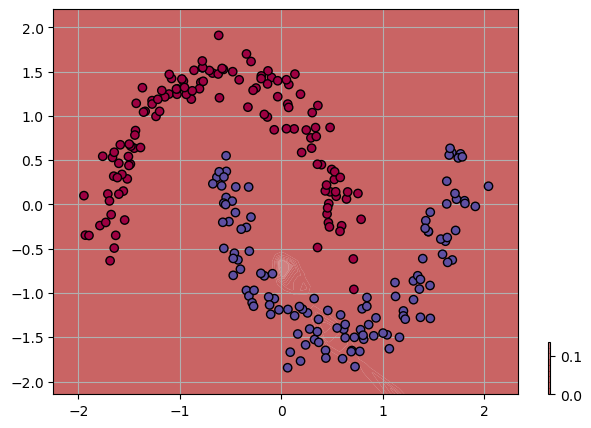

In [9]:
### CREATE A MESHGRID ###
# Create a meshgrid for the whole dataset such that we can plot the predictions for each point
h = .01  # step size in the mesh
buffer = 0.3 # buffer for the axes
x_min, x_max = X[:, 0].min() - buffer, X[:, 0].max() + buffer # min and max of the first feature
y_min, y_max = X[:, 1].min() - buffer, X[:, 1].max() + buffer # min and max of the second feature
xx,yy= np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
grid = np.c_[xx.ravel(), yy.ravel()]
grid = torch.from_numpy((grid - X.mean(axis=0)) / X.std(axis=0)).float().to(DEVICE)
# mincol in red hexa code, axcol in blue hexa code
custom_map = custom_div_cmap(
    11, mincol='#B22222', midcol='0.9', maxcol='#4863A0')

### SEED ###
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

### PREDICT ###
N_TEST_SAMPLES = 0
clevels = 9
Z = network.predict(grid, N_TEST_SAMPLES) 
Z = torch.stack(Z, dim=0)
Z = Z.mean(dim=0)
# Depending on the loss function, we need to apply an activation function to the output
if "binary_cross_entropy" in network_data["criterion"].__name__:
    Z = Z.cpu().reshape(xx.shape)
else:
    Z = torch.exp(Z)
    Z = torch.max(Z, dim=1)[0].reshape(xx.shape).cpu()

### PLOT ###
# Plot the predictions with the uncertainty
fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))
ax.grid(True)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Spectral, edgecolors='k', zorder=2)

# Plot the uncertainty with contourf based on the value of Z
c = ax.contourf(xx, yy, Z, alpha=0.7, levels=clevels, antialiased=True, cmap=custom_map, zorder=1)

# Add a colorbar
colorbar = fig.colorbar(c, ax=ax, ticks=np.arange(0, 1.1, 1 / (clevels+1)))
# force the leftbar to be between 0 and 1
c.get_clim()
c.set_clim(0, 1)
colorbar.ax.set_ylim(0, 1)

os.makedirs(SAVE_FOLDER, exist_ok=True)
plt.savefig(os.path.join(SAVE_FOLDER, "two-moons-uncertainty-DNN-mode.pdf"), bbox_inches='tight')
plt.show()


## <a id='toc1_5_'></a>[Binary Neural Networks](#toc0_)

### <a id='toc1_5_1_'></a>[Configuration and training of the network](#toc0_)

In [10]:

### NETWORK CONFIGURATION ###
network_data = {
    "nn_type": models.BiNN,
    "nn_parameters": {
        "layers": [INPUT_SIZE] + LAYER_SIZE + [OUT],
        "device": DEVICE,
        "dropout": False, # Dropout layers
        "batchnorm": False, # Batch normalization layers
        "bias": True,
        "latent_weights": False, # Latent weights for BNN
        "activation_function": Sign.apply, # Activation function for hidden layers
        "output_function": OUTPUT_FUNCTION, # Activation function for output layer (as loss function is BCE_with_logits, no activation function is needed)
    },
    "training_parameters": {
        'n_epochs': EPOCHS,
        'batch_size': BATCH_SIZE,
        'test_mcmc_samples': 1,
    },
    "criterion": CRITERION,
    "optimizer": BayesBiNN,
    "optimizer_parameters": {
        "temperature": 1,
        "num_mcmc_samples": 10,
        "init_lambda": 5,
        "lr": LEARNING_RATE,
        "beta": 0.99
    },
}

train_tensor = GPUTensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
test_tensor = GPUTensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

if "binary_cross_entropy" in network_data["criterion"].__name__:
    train_tensor.targets = train_tensor.targets.float().unsqueeze(1)
    test_tensor.targets = test_tensor.targets.float().unsqueeze(1)

train_loader = GPUDataLoader(train_tensor, batch_size=network_data["training_parameters"]["batch_size"], shuffle=True)
test_loader = GPUDataLoader(test_tensor, batch_size=te_size, shuffle=False)

### SEED ###
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

### ACCURACY INITIALIZATION ###
accuracies = []
batch_size = network_data['training_parameters']['batch_size']

### NETWORK INITIALIZATION ###
model = network_data['nn_type'](**network_data['nn_parameters'])

### INSTANTIATE THE TRAINER ###
network = trainer.BayesTrainer(batch_size=batch_size,
                                model=model, **network_data, device=DEVICE)
### TRAINING ###
network.fit(
    train_loader, 
    **network_data['training_parameters'], 
    test_loader=[test_loader, train_loader],
    name_loader=["Test accuracy", "Train accuracy"]
)

  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch 13/3000:   0%|          | 8/3000 [00:00<01:33, 31.87it/s, loss=2.91]

Testing accuracy: 
	Test accuracy: 46.00%
	Train accuracy: 38.80%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 46.00%
Testing accuracy: 
	Test accuracy: 38.00%
	Train accuracy: 36.40%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 50.80%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 70.00%
Testing accuracy: 
	Test accuracy: 44.00%
	Train accuracy: 10.00%
Testing accuracy: 
	Test accuracy: 42.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 56.00%
Testing accuracy: 
	Test accuracy: 50.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 34.80%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 65.20%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 67.20%


Epoch 26/3000:   1%|          | 22/3000 [00:00<00:57, 51.69it/s, loss=2]   

Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 63.60%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 46.40%
Testing accuracy: 
	Test accuracy: 36.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 51.20%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 72.40%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 67.20%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 72.80%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 46.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 65.20%


Epoch 41/3000:   1%|          | 36/3000 [00:00<00:49, 60.28it/s, loss=1.6] 

Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 67.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 72.40%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 64.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 65.20%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 70.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 67.20%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 38.80%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 90.00%


Epoch 52/3000:   2%|▏         | 50/3000 [00:01<00:51, 56.92it/s, loss=2.7] 

Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 56.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 77.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 74.80%


Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 70.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 77.20%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 67.20%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 88.00%


Epoch 78/3000:   3%|▎         | 78/3000 [00:01<00:46, 62.54it/s, loss=1.37]

	Train accuracy: 77.20%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 75.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 72.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%


Epoch 93/3000:   3%|▎         | 93/3000 [00:01<00:43, 67.57it/s, loss=1.4] 

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 74.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 73.60%


Epoch 106/3000:   3%|▎         | 100/3000 [00:01<00:45, 63.14it/s, loss=2.83]

Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 54.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 63.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 75.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%


Epoch 119/3000:   4%|▍         | 114/3000 [00:02<00:45, 62.75it/s, loss=1.84]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 75.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 50.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%


Epoch 132/3000:   4%|▍         | 128/3000 [00:02<00:45, 63.14it/s, loss=1.43]

Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 36.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 77.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 68.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 68.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 46.40%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 65.60%


Epoch 145/3000:   5%|▍         | 142/3000 [00:02<00:44, 64.43it/s, loss=1.36]

Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 46.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.20%


Epoch 156/3000:   5%|▌         | 156/3000 [00:02<00:46, 60.66it/s, loss=1.44]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 75.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 75.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 51.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 59.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%


Epoch 170/3000:   6%|▌         | 170/3000 [00:02<00:45, 62.85it/s, loss=1.61]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 63.60%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 49.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 66.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 82.40%


Epoch 183/3000:   6%|▌         | 177/3000 [00:03<00:44, 63.70it/s, loss=1.69]

Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 65.20%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 63.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 74.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%


Epoch 194/3000:   6%|▋         | 191/3000 [00:03<00:47, 58.93it/s, loss=2.17]

Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 75.20%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%


Epoch 203/3000:   7%|▋         | 203/3000 [00:03<00:54, 51.32it/s, loss=1.45]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 75.20%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 84.80%


Epoch 216/3000:   7%|▋         | 216/3000 [00:03<00:50, 55.42it/s, loss=1.16]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 48.80%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.00%


Epoch 228/3000:   7%|▋         | 223/3000 [00:03<00:48, 57.62it/s, loss=1.67]

Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 72.80%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%


Epoch 241/3000:   8%|▊         | 236/3000 [00:04<00:47, 58.60it/s, loss=1.65]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 62.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 68.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 70.40%


Epoch 255/3000:   8%|▊         | 249/3000 [00:04<00:45, 60.39it/s, loss=1.59]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%


Epoch 266/3000:   9%|▉         | 263/3000 [00:04<00:46, 58.67it/s, loss=1.46]

Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 75.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 73.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.00%


Epoch 278/3000:   9%|▉         | 276/3000 [00:04<00:46, 58.50it/s, loss=1.57]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 73.60%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%


Epoch 292/3000:  10%|▉         | 291/3000 [00:04<00:42, 63.79it/s, loss=1.25]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 82.40%


Epoch 306/3000:  10%|█         | 305/3000 [00:05<00:41, 65.68it/s, loss=1.59]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 77.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%


Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 75.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%


Epoch 333/3000:  11%|█         | 328/3000 [00:05<00:40, 65.87it/s, loss=1.44]

Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 70.80%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 74.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 65.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.20%


Epoch 346/3000:  11%|█▏        | 342/3000 [00:05<00:40, 64.99it/s, loss=1.83]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 65.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.60%


Epoch 359/3000:  12%|█▏        | 356/3000 [00:06<00:43, 60.86it/s, loss=2.38]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 54.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 65.20%


Epoch 370/3000:  12%|█▏        | 370/3000 [00:06<00:43, 60.57it/s, loss=1.24]

Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 61.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 77.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%


Epoch 385/3000:  13%|█▎        | 377/3000 [00:06<00:42, 61.42it/s, loss=1.59]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 58.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 84.80%


Epoch 398/3000:  13%|█▎        | 392/3000 [00:06<00:40, 64.52it/s, loss=1.61]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 87.60%


Epoch 411/3000:  14%|█▎        | 407/3000 [00:06<00:40, 63.80it/s, loss=1.32]

Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 63.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.60%


Epoch 425/3000:  14%|█▍        | 422/3000 [00:07<00:39, 65.75it/s, loss=1.35]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%


Epoch 439/3000:  15%|█▍        | 436/3000 [00:07<00:39, 65.36it/s, loss=2.68]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 65.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%


Epoch 453/3000:  15%|█▌        | 450/3000 [00:07<00:39, 64.66it/s, loss=1.25] 

Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%


Epoch 465/3000:  15%|█▌        | 464/3000 [00:07<00:39, 63.85it/s, loss=2.02]

Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%


Epoch 479/3000:  16%|█▌        | 478/3000 [00:07<00:37, 66.53it/s, loss=1.28]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 73.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 82.00%


Epoch 492/3000:  16%|█▋        | 492/3000 [00:08<00:39, 64.19it/s, loss=1.41]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%


Epoch 506/3000:  17%|█▋        | 499/3000 [00:08<00:40, 61.15it/s, loss=1.52]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 72.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 70.00%


Epoch 519/3000:  17%|█▋        | 514/3000 [00:08<00:38, 64.31it/s, loss=1.77]

	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%


Epoch 533/3000:  18%|█▊        | 529/3000 [00:08<00:36, 66.82it/s, loss=1.48]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%


Epoch 545/3000:  18%|█▊        | 543/3000 [00:08<00:38, 64.04it/s, loss=1.7] 

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%


Epoch 558/3000:  19%|█▊        | 557/3000 [00:09<00:39, 61.09it/s, loss=1.85]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.20%


Epoch 571/3000:  19%|█▉        | 571/3000 [00:09<00:38, 63.06it/s, loss=1.77]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 74.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 87.60%


Epoch 585/3000:  20%|█▉        | 585/3000 [00:09<00:37, 64.14it/s, loss=1.54]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%


Epoch 598/3000:  20%|█▉        | 592/3000 [00:09<00:38, 61.90it/s, loss=1.47]

Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%


Epoch 610/3000:  20%|██        | 607/3000 [00:09<00:37, 64.23it/s, loss=2.09]

	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 73.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 87.60%


Epoch 623/3000:  21%|██        | 621/3000 [00:10<00:39, 60.75it/s, loss=1.7] 

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 84.80%


Epoch 636/3000:  21%|██        | 635/3000 [00:10<00:37, 62.46it/s, loss=2.75]

Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%


Epoch 649/3000:  22%|██▏       | 649/3000 [00:10<00:37, 62.33it/s, loss=1.83]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%


Epoch 663/3000:  22%|██▏       | 663/3000 [00:10<00:36, 64.46it/s, loss=1.61]

Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 87.60%


Epoch 676/3000:  22%|██▏       | 670/3000 [00:10<00:36, 64.62it/s, loss=1.49]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 52.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 82.40%


Epoch 687/3000:  23%|██▎       | 684/3000 [00:11<00:37, 61.87it/s, loss=1.52]

Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 68.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%


Epoch 700/3000:  23%|██▎       | 698/3000 [00:11<00:39, 58.87it/s, loss=1.51]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 82.40%


Epoch 713/3000:  24%|██▎       | 712/3000 [00:11<00:36, 62.13it/s, loss=2.86]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%


Epoch 727/3000:  24%|██▍       | 726/3000 [00:11<00:35, 64.09it/s, loss=1.56]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 79.60%


Epoch 740/3000:  24%|██▍       | 733/3000 [00:12<00:37, 61.20it/s, loss=2.44]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 82.40%


Epoch 750/3000:  25%|██▍       | 748/3000 [00:12<00:37, 59.48it/s, loss=1.41]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 68.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 82.40%


Epoch 764/3000:  25%|██▌       | 762/3000 [00:12<00:35, 63.23it/s, loss=1.43]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 68.40%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%


Epoch 779/3000:  26%|██▌       | 778/3000 [00:12<00:32, 68.39it/s, loss=1.3]  

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 68.00%


Epoch 794/3000:  26%|██▋       | 793/3000 [00:12<00:32, 67.87it/s, loss=1.47]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%


Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 68.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 


Epoch 821/3000:  27%|██▋       | 815/3000 [00:13<00:32, 68.26it/s, loss=1.89]

	Test accuracy: 88.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accu

Epoch 835/3000:  28%|██▊       | 831/3000 [00:13<00:30, 70.42it/s, loss=1.41]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 90.00%


Epoch 849/3000:  28%|██▊       | 847/3000 [00:13<00:30, 70.31it/s, loss=1.32]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%


Epoch 864/3000:  29%|██▉       | 863/3000 [00:13<00:30, 69.76it/s, loss=1.4] 

Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%


Epoch 881/3000:  29%|██▉       | 881/3000 [00:14<00:27, 76.87it/s, loss=2.44]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing ac

Epoch 899/3000:  30%|██▉       | 890/3000 [00:14<00:26, 79.16it/s, loss=1.34]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing ac

Epoch 913/3000:  30%|███       | 908/3000 [00:14<00:25, 81.30it/s, loss=2.68]

	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%


Epoch 930/3000:  31%|███       | 925/3000 [00:14<00:26, 77.42it/s, loss=1.68]

Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.40%
Testing ac

Epoch 944/3000:  31%|███▏      | 941/3000 [00:14<00:26, 76.64it/s, loss=2.62]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%


Epoch 960/3000:  32%|███▏      | 958/3000 [00:15<00:27, 74.72it/s, loss=2.43]

Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing ac

Epoch 976/3000:  32%|███▏      | 974/3000 [00:15<00:27, 74.24it/s, loss=1.46]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing ac

Epoch 988/3000:  33%|███▎      | 982/3000 [00:15<00:26, 75.85it/s, loss=1.47]

	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%


Epoch 1004/3000:  33%|███▎      | 998/3000 [00:15<00:28, 69.37it/s, loss=2.62]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%


Epoch 1019/3000:  34%|███▍      | 1015/3000 [00:15<00:26, 74.48it/s, loss=1.91]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 90.00%
Testing ac

Epoch 1035/3000:  34%|███▍      | 1031/3000 [00:16<00:26, 74.85it/s, loss=2.85]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 78.00%
Testing ac

Epoch 1050/3000:  35%|███▍      | 1047/3000 [00:16<00:26, 72.50it/s, loss=1.83]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%


Epoch 1066/3000:  35%|███▌      | 1063/3000 [00:16<00:26, 73.75it/s, loss=1.73]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%


Epoch 1082/3000:  36%|███▌      | 1080/3000 [00:16<00:24, 77.49it/s, loss=1.44]

Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing ac

Epoch 1098/3000:  37%|███▋      | 1097/3000 [00:16<00:24, 77.58it/s, loss=1.48]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing ac

Epoch 1113/3000:  37%|███▋      | 1113/3000 [00:17<00:24, 77.18it/s, loss=2.7] 

	Test accuracy: 70.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 68.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 70.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accu

Epoch 1129/3000:  38%|███▊      | 1129/3000 [00:17<00:24, 77.52it/s, loss=2.5] 

Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 73.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%
Testing ac

Epoch 1146/3000:  38%|███▊      | 1138/3000 [00:17<00:23, 78.72it/s, loss=1.96]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing ac

Epoch 1162/3000:  38%|███▊      | 1155/3000 [00:17<00:23, 77.71it/s, loss=1.61]

Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 68.00%
Testing ac

Epoch 1176/3000:  39%|███▉      | 1171/3000 [00:17<00:24, 73.57it/s, loss=1.75]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%


Epoch 1193/3000:  40%|███▉      | 1188/3000 [00:18<00:23, 77.09it/s, loss=1.79]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing ac

Epoch 1210/3000:  40%|████      | 1206/3000 [00:18<00:22, 79.24it/s, loss=1.44]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing ac

Epoch 1221/3000:  40%|████      | 1214/3000 [00:18<00:22, 78.50it/s, loss=1.71]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 87.60%


Epoch 1238/3000:  41%|████      | 1231/3000 [00:18<00:25, 70.31it/s, loss=1.48]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing ac

Epoch 1255/3000:  42%|████▏     | 1249/3000 [00:19<00:23, 75.74it/s, loss=1.65]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing ac

Epoch 1268/3000:  42%|████▏     | 1265/3000 [00:19<00:24, 72.25it/s, loss=1.32]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%


Epoch 1284/3000:  43%|████▎     | 1281/3000 [00:19<00:24, 71.39it/s, loss=1.96]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%


Epoch 1298/3000:  43%|████▎     | 1290/3000 [00:19<00:22, 74.84it/s, loss=2.8] 

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 73.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 


Epoch 1312/3000:  44%|████▎     | 1306/3000 [00:19<00:24, 69.63it/s, loss=1.43]

	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.40%


Epoch 1327/3000:  44%|████▍     | 1323/3000 [00:20<00:23, 72.68it/s, loss=1.68]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 59.20%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing ac

Epoch 1344/3000:  45%|████▍     | 1341/3000 [00:20<00:21, 77.51it/s, loss=1.5] 

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 73.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing ac

Epoch 1361/3000:  45%|████▌     | 1358/3000 [00:20<00:20, 79.22it/s, loss=3.66]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 73.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing ac

Epoch 1371/3000:  46%|████▌     | 1366/3000 [00:20<00:22, 73.68it/s, loss=1.54]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 73.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%


Epoch 1384/3000:  46%|████▌     | 1381/3000 [00:20<00:26, 62.27it/s, loss=1.53]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%


Epoch 1395/3000:  46%|████▋     | 1395/3000 [00:21<00:26, 60.89it/s, loss=1.62]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%


Epoch 1408/3000:  47%|████▋     | 1402/3000 [00:21<00:25, 61.47it/s, loss=2.51]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%


Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%


Epoch 1432/3000:  48%|████▊     | 1430/3000 [00:21<00:26, 59.63it/s, loss=1.31]

Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%


Epoch 1446/3000:  48%|████▊     | 1445/3000 [00:21<00:24, 62.83it/s, loss=1.79]

Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 70.40%


Epoch 1458/3000:  48%|████▊     | 1452/3000 [00:22<00:24, 63.43it/s, loss=1.54]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 66.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 68.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%


Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 72.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%


Epoch 1483/3000:  49%|████▉     | 1480/3000 [00:22<00:24, 60.85it/s, loss=1.66]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%


Epoch 1495/3000:  50%|████▉     | 1493/3000 [00:22<00:26, 57.44it/s, loss=1.49]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.60%
Testing accuracy: 


Epoch 1507/3000:  50%|█████     | 1507/3000 [00:22<00:24, 60.10it/s, loss=2.56]

	Test accuracy: 74.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 66.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 68.00%


Epoch 1521/3000:  50%|█████     | 1514/3000 [00:23<00:24, 61.32it/s, loss=2.47]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.00%


Epoch 1535/3000:  51%|█████     | 1530/3000 [00:23<00:23, 63.64it/s, loss=1.72]

Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 68.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 68.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 87.60%


Epoch 1548/3000:  51%|█████▏    | 1544/3000 [00:23<00:22, 64.89it/s, loss=1.51]

Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 66.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%


Epoch 1563/3000:  52%|█████▏    | 1559/3000 [00:23<00:21, 66.66it/s, loss=1.48]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%


Epoch 1574/3000:  52%|█████▏    | 1573/3000 [00:23<00:22, 63.32it/s, loss=1.69]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.40%


Epoch 1586/3000:  53%|█████▎    | 1580/3000 [00:24<00:23, 61.05it/s, loss=1.54]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 90.00%


Epoch 1598/3000:  53%|█████▎    | 1594/3000 [00:24<00:23, 58.94it/s, loss=1.67]

Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 63.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%


Epoch 1609/3000:  54%|█████▎    | 1607/3000 [00:24<00:23, 59.70it/s, loss=1.54]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 63.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 63.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 90.00%


Epoch 1621/3000:  54%|█████▍    | 1619/3000 [00:24<00:24, 56.66it/s, loss=2.06]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 51.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 87.60%


Epoch 1633/3000:  54%|█████▍    | 1631/3000 [00:25<00:24, 57.04it/s, loss=1.51]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%


Epoch 1646/3000:  55%|█████▍    | 1644/3000 [00:25<00:23, 58.22it/s, loss=1.7] 

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.00%


Epoch 1658/3000:  55%|█████▌    | 1657/3000 [00:25<00:22, 59.20it/s, loss=2.67]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%


Epoch 1671/3000:  56%|█████▌    | 1671/3000 [00:25<00:22, 59.63it/s, loss=1.32]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 73.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%


Epoch 1683/3000:  56%|█████▌    | 1678/3000 [00:25<00:21, 60.86it/s, loss=1.43]

Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 90.00%


Epoch 1695/3000:  56%|█████▋    | 1691/3000 [00:26<00:23, 56.76it/s, loss=1.91]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%


Epoch 1709/3000:  57%|█████▋    | 1705/3000 [00:26<00:21, 61.42it/s, loss=2.35]

Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 73.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 54.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%


Epoch 1722/3000:  57%|█████▋    | 1719/3000 [00:26<00:20, 61.92it/s, loss=4.53]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 54.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 78.00%


Epoch 1732/3000:  58%|█████▊    | 1726/3000 [00:26<00:20, 61.18it/s, loss=1.52]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 70.40%


Epoch 1745/3000:  58%|█████▊    | 1739/3000 [00:26<00:22, 56.56it/s, loss=2.5] 

Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%


Epoch 1758/3000:  58%|█████▊    | 1753/3000 [00:27<00:20, 60.17it/s, loss=2.51]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 59.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%


Epoch 1771/3000:  59%|█████▉    | 1767/3000 [00:27<00:20, 60.37it/s, loss=1.52]

Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 79.60%


Epoch 1783/3000:  59%|█████▉    | 1781/3000 [00:27<00:20, 58.83it/s, loss=1.47]

Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%


Epoch 1795/3000:  60%|█████▉    | 1795/3000 [00:27<00:20, 59.02it/s, loss=1.54]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%


Epoch 1809/3000:  60%|██████    | 1809/3000 [00:27<00:19, 62.49it/s, loss=1.5] 

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.20%


Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 


Epoch 1833/3000:  61%|██████    | 1830/3000 [00:28<00:19, 61.34it/s, loss=1.46]

	Test accuracy: 78.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 50.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 71.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%


Epoch 1844/3000:  61%|██████▏   | 1843/3000 [00:28<00:20, 55.78it/s, loss=1.68]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 71.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 58.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%


Epoch 1858/3000:  62%|██████▏   | 1857/3000 [00:28<00:18, 61.76it/s, loss=1.7] 

Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%


Epoch 1872/3000:  62%|██████▏   | 1871/3000 [00:28<00:17, 63.55it/s, loss=2.36]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%


Epoch 1885/3000:  63%|██████▎   | 1885/3000 [00:29<00:17, 63.96it/s, loss=1.49]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%


Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%


Epoch 1911/3000:  64%|██████▎   | 1906/3000 [00:29<00:17, 62.60it/s, loss=1.51]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 68.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%


Epoch 1923/3000:  64%|██████▍   | 1920/3000 [00:29<00:17, 61.78it/s, loss=1.26]

	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%


Epoch 1932/3000:  64%|██████▍   | 1927/3000 [00:30<00:18, 57.45it/s, loss=2.69]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 87.60%


Epoch 1944/3000:  65%|██████▍   | 1939/3000 [00:30<00:20, 52.66it/s, loss=1.91]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 90.00%


Epoch 1957/3000:  65%|██████▌   | 1952/3000 [00:30<00:18, 56.24it/s, loss=1.38]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%


Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%


	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 59.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.20%
Testing accuracy: 


Epoch 1992/3000:  66%|██████▋   | 1991/3000 [00:31<00:18, 56.04it/s, loss=1.51]

	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 59.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%


Epoch 2002/3000:  67%|██████▋   | 1997/3000 [00:31<00:18, 55.33it/s, loss=2.72]

Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 75.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 68.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%


Epoch 2016/3000:  67%|██████▋   | 2010/3000 [00:31<00:16, 58.92it/s, loss=1.72]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 80.40%


Epoch 2028/3000:  67%|██████▋   | 2024/3000 [00:31<00:16, 60.46it/s, loss=2.63]

Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%


Epoch 2040/3000:  68%|██████▊   | 2038/3000 [00:31<00:16, 59.23it/s, loss=2.53]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%


Epoch 2053/3000:  68%|██████▊   | 2051/3000 [00:32<00:15, 59.81it/s, loss=1.52]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%


Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%


Epoch 2080/3000:  69%|██████▉   | 2079/3000 [00:32<00:14, 65.21it/s, loss=1.43]

	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 68.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 87.60%


Epoch 2092/3000:  70%|██████▉   | 2086/3000 [00:32<00:15, 60.93it/s, loss=2.64]

Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 70.80%


Epoch 2107/3000:  70%|███████   | 2101/3000 [00:32<00:13, 65.10it/s, loss=1.86]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%


Epoch 2123/3000:  71%|███████   | 2117/3000 [00:33<00:12, 71.18it/s, loss=1.35]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 77.60%
Testing ac

Epoch 2139/3000:  71%|███████   | 2133/3000 [00:33<00:12, 72.21it/s, loss=1.66]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%


Epoch 2155/3000:  72%|███████▏  | 2151/3000 [00:33<00:11, 77.03it/s, loss=1.43]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing ac

Epoch 2168/3000:  72%|███████▏  | 2167/3000 [00:33<00:11, 71.74it/s, loss=2.65]

	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%


Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%


Epoch 2197/3000:  73%|███████▎  | 2192/3000 [00:34<00:11, 70.37it/s, loss=2.54]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 50.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%


Epoch 2209/3000:  74%|███████▎  | 2207/3000 [00:34<00:12, 66.00it/s, loss=2.85]

	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%


Epoch 2222/3000:  74%|███████▍  | 2221/3000 [00:34<00:12, 64.01it/s, loss=3.89]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.20%


Epoch 2234/3000:  74%|███████▍  | 2228/3000 [00:34<00:11, 64.67it/s, loss=2.58]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 75.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 84.80%


Epoch 2246/3000:  75%|███████▍  | 2242/3000 [00:34<00:12, 60.12it/s, loss=1.61]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%


Epoch 2259/3000:  75%|███████▌  | 2256/3000 [00:35<00:12, 58.79it/s, loss=1.09]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%


Epoch 2271/3000:  76%|███████▌  | 2271/3000 [00:35<00:11, 60.77it/s, loss=2.8] 

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%


Epoch 2284/3000:  76%|███████▌  | 2278/3000 [00:35<00:12, 59.11it/s, loss=1.78]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%


Epoch 2296/3000:  76%|███████▋  | 2293/3000 [00:35<00:11, 63.28it/s, loss=1.63]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%


Epoch 2309/3000:  77%|███████▋  | 2307/3000 [00:35<00:11, 61.11it/s, loss=2.39]

	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.40%


Epoch 2323/3000:  77%|███████▋  | 2321/3000 [00:36<00:10, 63.83it/s, loss=1.67]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 50.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%


Epoch 2336/3000:  78%|███████▊  | 2335/3000 [00:36<00:10, 64.10it/s, loss=3.99]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%


Epoch 2349/3000:  78%|███████▊  | 2349/3000 [00:36<00:10, 63.26it/s, loss=1.7] 

Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 71.20%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%


Epoch 2362/3000:  79%|███████▊  | 2356/3000 [00:36<00:10, 62.75it/s, loss=1.75]

Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 71.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 80.40%


Epoch 2375/3000:  79%|███████▉  | 2370/3000 [00:37<00:10, 62.12it/s, loss=2.26]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 68.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%


Epoch 2387/3000:  79%|███████▉  | 2384/3000 [00:37<00:10, 60.11it/s, loss=2.37]

Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 61.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%


Epoch 2401/3000:  80%|███████▉  | 2398/3000 [00:37<00:09, 63.09it/s, loss=1.38]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 60.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%


Epoch 2415/3000:  80%|████████  | 2412/3000 [00:37<00:09, 64.54it/s, loss=2.69]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 73.60%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 84.80%


Epoch 2430/3000:  81%|████████  | 2427/3000 [00:37<00:08, 68.48it/s, loss=1.54]

Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 54.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%


Epoch 2447/3000:  81%|████████▏ | 2444/3000 [00:38<00:07, 74.74it/s, loss=2.5] 

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 68.00%
Testing ac

Epoch 2463/3000:  82%|████████▏ | 2461/3000 [00:38<00:06, 77.19it/s, loss=3.59]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 68.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 74.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing ac

Epoch 2480/3000:  83%|████████▎ | 2479/3000 [00:38<00:06, 80.32it/s, loss=1.87]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing ac

Epoch 2495/3000:  83%|████████▎ | 2488/3000 [00:38<00:06, 81.37it/s, loss=1.66]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 75.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%


Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing ac

Epoch 2526/3000:  84%|████████▍ | 2522/3000 [00:39<00:06, 73.24it/s, loss=1.62]

	Test accuracy: 80.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 71.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 51.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%


Epoch 2542/3000:  85%|████████▍ | 2539/3000 [00:39<00:05, 77.82it/s, loss=1.48]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing ac

Epoch 2559/3000:  85%|████████▌ | 2556/3000 [00:39<00:05, 79.24it/s, loss=1.16]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 68.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 87.60%
Testing ac

Epoch 2574/3000:  86%|████████▌ | 2573/3000 [00:39<00:05, 76.07it/s, loss=1.49]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%


Epoch 2589/3000:  86%|████████▌ | 2582/3000 [00:39<00:05, 77.79it/s, loss=1.95]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 68.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%


Epoch 2602/3000:  87%|████████▋ | 2598/3000 [00:40<00:05, 68.73it/s, loss=1.96]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%


Epoch 2617/3000:  87%|████████▋ | 2614/3000 [00:40<00:05, 70.94it/s, loss=1.06]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%


Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%


Epoch 2647/3000:  88%|████████▊ | 2647/3000 [00:40<00:04, 72.35it/s, loss=1.56]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%


Epoch 2664/3000:  89%|████████▊ | 2656/3000 [00:40<00:04, 75.73it/s, loss=1.36]

Testing accuracy: 
	Test accuracy: 50.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing ac

Epoch 2677/3000:  89%|████████▉ | 2673/3000 [00:41<00:04, 76.11it/s, loss=3.71]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.00%


Epoch 2689/3000:  90%|████████▉ | 2688/3000 [00:41<00:04, 65.53it/s, loss=1.83]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 68.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%


Epoch 2702/3000:  90%|█████████ | 2702/3000 [00:41<00:04, 61.95it/s, loss=2.69]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 66.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%


Epoch 2715/3000:  90%|█████████ | 2709/3000 [00:41<00:04, 61.04it/s, loss=3.08]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%


Epoch 2729/3000:  91%|█████████ | 2723/3000 [00:41<00:04, 62.16it/s, loss=1.29]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 90.00%


Epoch 2743/3000:  91%|█████████▏| 2738/3000 [00:42<00:04, 63.85it/s, loss=1.65]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%


Epoch 2757/3000:  92%|█████████▏| 2753/3000 [00:42<00:03, 67.49it/s, loss=2.8] 

Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%


Epoch 2767/3000:  92%|█████████▏| 2767/3000 [00:42<00:03, 60.64it/s, loss=1.52]

	Train accuracy: 75.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%


Epoch 2780/3000:  92%|█████████▏| 2774/3000 [00:42<00:03, 61.26it/s, loss=1.72]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%


Epoch 2793/3000:  93%|█████████▎| 2788/3000 [00:43<00:03, 62.13it/s, loss=1.64]

Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%


Epoch 2805/3000:  93%|█████████▎| 2802/3000 [00:43<00:03, 60.23it/s, loss=1.48]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%


Epoch 2819/3000:  94%|█████████▍| 2816/3000 [00:43<00:02, 63.10it/s, loss=1.62]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%


Epoch 2833/3000:  94%|█████████▍| 2831/3000 [00:43<00:02, 64.98it/s, loss=1.84]

Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 61.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 80.40%


Epoch 2848/3000:  95%|█████████▍| 2846/3000 [00:43<00:02, 67.59it/s, loss=2.41]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%


Epoch 2860/3000:  95%|█████████▌| 2853/3000 [00:44<00:02, 63.67it/s, loss=1.49]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%


Epoch 2875/3000:  96%|█████████▌| 2869/3000 [00:44<00:01, 68.10it/s, loss=1.59]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.40%


Epoch 2890/3000:  96%|█████████▌| 2885/3000 [00:44<00:01, 69.88it/s, loss=4.02]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 90.00%


Epoch 2904/3000:  97%|█████████▋| 2900/3000 [00:44<00:01, 68.24it/s, loss=1.75]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 67.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%


Epoch 2914/3000:  97%|█████████▋| 2914/3000 [00:44<00:01, 60.68it/s, loss=1.22]

Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 73.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 54.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%


Epoch 2927/3000:  97%|█████████▋| 2921/3000 [00:45<00:01, 61.15it/s, loss=2.81]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%


Epoch 2940/3000:  98%|█████████▊| 2935/3000 [00:45<00:01, 61.78it/s, loss=1.72]

Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 56.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 87.60%


Epoch 2952/3000:  98%|█████████▊| 2949/3000 [00:45<00:00, 58.82it/s, loss=1.2] 

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 66.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 65.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%


Epoch 2964/3000:  99%|█████████▉| 2963/3000 [00:45<00:00, 60.37it/s, loss=1.72]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%


Epoch 2977/3000:  99%|█████████▉| 2977/3000 [00:45<00:00, 60.57it/s, loss=1.28]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 77.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 78.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 70.40%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 68.00%


Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 68.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 64.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%


Epoch 3000/3000: 100%|██████████| 3000/3000 [00:46<00:00, 64.85it/s, loss=1.57]

	Train accuracy: 80.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.60%


### <a id='toc1_5_2_'></a>[Exploiting the results](#toc0_)

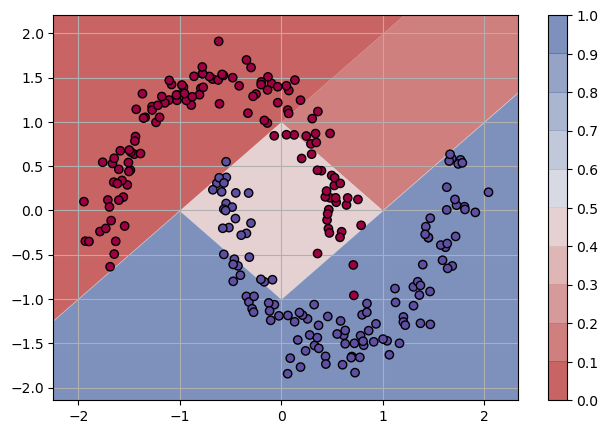

In [11]:
### CREATE A MESHGRID ###
# Create a meshgrid for the whole dataset such that we can plot the predictions for each point
h = .01  # step size in the mesh
buffer = 0.3 # buffer for the axes
x_min, x_max = X[:, 0].min() - buffer, X[:, 0].max() + buffer # min and max of the first feature
y_min, y_max = X[:, 1].min() - buffer, X[:, 1].max() + buffer # min and max of the second feature
xx,yy= np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
grid = np.c_[xx.ravel(), yy.ravel()]
grid = torch.from_numpy((grid - X.mean(axis=0)) / X.std(axis=0)).float().to(DEVICE)
# mincol in red hexa code, axcol in blue hexa code
custom_map = custom_div_cmap(
    11, mincol='#B22222', midcol='0.9', maxcol='#4863A0')

### SEED ###
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

### PREDICT ###
N_TEST_SAMPLES = 10
clevels = 9
Z = network.predict(grid, N_TEST_SAMPLES) 
Z = torch.stack(Z, dim=0)
Z = Z.mean(dim=0)
# Depending on the loss function, we need to apply an activation function to the output
if "binary_cross_entropy" in network_data["criterion"].__name__:
    Z = Z.cpu().reshape(xx.shape)
else:    
    Z = torch.exp(Z)
    Z = torch.max(Z, dim=1)[0].reshape(xx.shape).cpu()

### PLOT ###
# Plot the predictions with the uncertainty
fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))
ax.grid(True)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Spectral, edgecolors='k', zorder=2)

# Plot the uncertainty with contourf based on the value of Z
c = ax.contourf(xx, yy, Z, alpha=0.7, levels=clevels, antialiased=True, cmap=custom_map, zorder=1)

# Add a colorbar
# Add a colorbar
colorbar = fig.colorbar(c, ax=ax, ticks=np.arange(0, 1.1, 1 / (clevels+1)))
# force the leftbar to be between 0 and 1
c.get_clim()
c.set_clim(0, 1)
colorbar.ax.set_ylim(0, 1)

os.makedirs(SAVE_FOLDER, exist_ok=True)
plt.savefig(os.path.join(SAVE_FOLDER, "two-moons-uncertainty-Bayes-BiNN.pdf"), bbox_inches='tight')
plt.show()

### <a id='toc1_5_3_'></a>[Straight Through Estimator with tanh](#toc0_)

In [12]:

### NETWORK CONFIGURATION ###
network_data = {
    "nn_type": models.BiNN,
    "nn_parameters": {
        "layers": [INPUT_SIZE] + LAYER_SIZE + [OUT],
        "device": DEVICE,
        "bias": True,
        "activation_function": torch.functional.F.tanh, # Activation function for hidden layers
        "output_function": OUTPUT_FUNCTION, # Activation function for output layer (as loss function is BCE_with_logits, no activation function is needed)
    },
    "training_parameters": {
        'n_epochs': EPOCHS,
        'batch_size': BATCH_SIZE,
    },
    "criterion": CRITERION,
    "optimizer": torch.optim.Adam,
    "optimizer_parameters": {
        "lr": LEARNING_RATE,
    },
}

train_tensor = GPUTensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
test_tensor = GPUTensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

if "binary_cross_entropy" in network_data["criterion"].__name__:
    train_tensor.targets = train_tensor.targets.float().unsqueeze(1)
    test_tensor.targets = test_tensor.targets.float().unsqueeze(1)

train_loader = GPUDataLoader(train_tensor, batch_size=network_data["training_parameters"]["batch_size"], shuffle=True)
test_loader = GPUDataLoader(test_tensor, batch_size=te_size, shuffle=False)

### SEED ###
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

### ACCURACY INITIALIZATION ###
accuracies = []
batch_size = network_data['training_parameters']['batch_size']

### NETWORK INITIALIZATION ###
model = network_data['nn_type'](**network_data['nn_parameters'])

### INSTANTIATE THE TRAINER ###
network = trainer.GPUTrainer(batch_size=batch_size,
                                model=model, **network_data, device=DEVICE)
### TRAINING ###
network.fit(
    train_loader, 
    **network_data['training_parameters'], 
    test_loader=[test_loader, train_loader],
    name_loader=["Test accuracy", "Train accuracy"]
)

Epoch 32/3000:   1%|          | 28/3000 [00:00<00:21, 139.42it/s, loss=0.00333]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Te

Epoch 61/3000:   2%|▏         | 60/3000 [00:00<00:20, 146.97it/s, loss=0.000999]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy

Epoch 89/3000:   2%|▎         | 75/3000 [00:00<00:20, 139.42it/s, loss=0.00144] 

	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Tes

Epoch 122/3000:   4%|▎         | 107/3000 [00:00<00:19, 148.89it/s, loss=0.00142] 

	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Tes

Epoch 153/3000:   5%|▍         | 140/3000 [00:01<00:18, 152.78it/s, loss=0.00507] 

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Trai

Epoch 186/3000:   6%|▌         | 174/3000 [00:01<00:17, 158.31it/s, loss=0.00597]

	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accura

Epoch 215/3000:   7%|▋         | 207/3000 [00:01<00:18, 151.69it/s, loss=0.00122] 

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accu

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train acc

	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test acc

Epoch 308/3000:  10%|█         | 304/3000 [00:02<00:17, 157.33it/s, loss=0.00638]

	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testin

Epoch 339/3000:  11%|█         | 337/3000 [00:02<00:16, 159.89it/s, loss=0.00966]

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy

Epoch 371/3000:  12%|█▏        | 354/3000 [00:02<00:17, 151.23it/s, loss=0.00479]

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
T

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accurac

Epoch 424/3000:  14%|█▍        | 417/3000 [00:02<00:18, 140.60it/s, loss=0.0017] 

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy:

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 9

Epoch 481/3000:  16%|█▌        | 476/3000 [00:03<00:17, 140.40it/s, loss=0.00405]

	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Te

Epoch 511/3000:  17%|█▋        | 508/3000 [00:03<00:17, 146.03it/s, loss=0.00388]

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.2

Epoch 542/3000:  18%|█▊        | 540/3000 [00:03<00:16, 151.71it/s, loss=0.00178] 

	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testin

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy:

	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing 

	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.

Epoch 663/3000:  22%|██▏       | 650/3000 [00:04<00:15, 151.97it/s, loss=0.00489]

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.

Epoch 695/3000:  23%|██▎       | 682/3000 [00:04<00:15, 152.66it/s, loss=0.0073] 

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99

Epoch 723/3000:  24%|██▍       | 714/3000 [00:04<00:15, 145.66it/s, loss=0.0219] 

	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 10

Epoch 756/3000:  25%|██▍       | 748/3000 [00:05<00:14, 155.70it/s, loss=0.0092] 

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60

Epoch 780/3000:  26%|██▌       | 780/3000 [00:05<00:15, 139.94it/s, loss=0.0237] 

	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing 

Epoch 808/3000:  27%|██▋       | 796/3000 [00:05<00:15, 143.27it/s, loss=0.0483] 

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Tes

Epoch 840/3000:  28%|██▊       | 827/3000 [00:05<00:15, 141.22it/s, loss=0.00642]

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy

Epoch 874/3000:  29%|██▊       | 861/3000 [00:05<00:14, 151.75it/s, loss=0.0161] 

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accu

Epoch 904/3000:  30%|██▉       | 894/3000 [00:06<00:13, 154.82it/s, loss=0.00303] 

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train acc

Epoch 930/3000:  31%|███       | 925/3000 [00:06<00:14, 144.35it/s, loss=0.00333]

	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing a

Epoch 959/3000:  32%|███▏      | 955/3000 [00:06<00:14, 142.41it/s, loss=0.0113] 

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.

Epoch 985/3000:  32%|███▏      | 971/3000 [00:06<00:13, 145.16it/s, loss=0.0258] 

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60

Epoch 1011/3000:  33%|███▎      | 1000/3000 [00:06<00:15, 130.66it/s, loss=0.0147] 

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20

Epoch 1041/3000:  34%|███▍      | 1031/3000 [00:07<00:14, 139.01it/s, loss=0.0172] 

Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testin

Epoch 1069/3000:  35%|███▌      | 1062/3000 [00:07<00:13, 143.09it/s, loss=0.0139] 

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 92.80

Epoch 1099/3000:  36%|███▋      | 1093/3000 [00:07<00:13, 145.19it/s, loss=0.00774]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Tes

Epoch 1122/3000:  37%|███▋      | 1122/3000 [00:07<00:14, 126.00it/s, loss=0.0066] 

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.

Epoch 1150/3000:  38%|███▊      | 1135/3000 [00:07<00:14, 124.50it/s, loss=0.00214] 

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train

Epoch 1181/3000:  39%|███▉      | 1169/3000 [00:08<00:12, 146.01it/s, loss=0.0273] 

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train acc

Epoch 1213/3000:  40%|████      | 1201/3000 [00:08<00:12, 147.48it/s, loss=0.00864]

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.6

Epoch 1243/3000:  41%|████      | 1233/3000 [00:08<00:11, 151.11it/s, loss=0.00627]

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.8

Epoch 1272/3000:  42%|████▏     | 1266/3000 [00:08<00:11, 149.73it/s, loss=0.011]  

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99

Epoch 1299/3000:  43%|████▎     | 1297/3000 [00:08<00:12, 139.81it/s, loss=0.015]  

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99

Epoch 1328/3000:  44%|████▍     | 1327/3000 [00:09<00:12, 138.76it/s, loss=0.0114] 

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.6

Epoch 1359/3000:  45%|████▍     | 1344/3000 [00:09<00:11, 143.34it/s, loss=0.149]  

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%

Epoch 1383/3000:  46%|████▌     | 1374/3000 [00:09<00:11, 138.73it/s, loss=0.00954]

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%

Epoch 1416/3000:  47%|████▋     | 1404/3000 [00:09<00:11, 139.72it/s, loss=0.0155] 

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.8

Epoch 1446/3000:  48%|████▊     | 1438/3000 [00:09<00:10, 148.50it/s, loss=0.0961] 

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99

Epoch 1476/3000:  49%|████▉     | 1469/3000 [00:10<00:10, 148.24it/s, loss=0.0129]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.80

Epoch 1504/3000:  50%|████▉     | 1499/3000 [00:10<00:10, 143.38it/s, loss=0.0292] 

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.40%

Epoch 1563/3000:  52%|█████▏    | 1561/3000 [00:10<00:09, 147.24it/s, loss=0.025]  

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 96.4

Epoch 1590/3000:  53%|█████▎    | 1576/3000 [00:10<00:09, 144.64it/s, loss=0.00627]

	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%

Epoch 1620/3000:  54%|█████▎    | 1607/3000 [00:11<00:09, 144.35it/s, loss=0.0104] 

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 9

Epoch 1676/3000:  56%|█████▌    | 1668/3000 [00:11<00:09, 142.21it/s, loss=0.00297]

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train acc

Epoch 1705/3000:  57%|█████▋    | 1699/3000 [00:11<00:09, 140.30it/s, loss=0.165]  

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 

Epoch 1736/3000:  58%|█████▊    | 1732/3000 [00:11<00:08, 149.35it/s, loss=0.00293]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Te

Epoch 1765/3000:  59%|█████▉    | 1765/3000 [00:12<00:08, 144.71it/s, loss=0.00583]

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy

Epoch 1790/3000:  59%|█████▉    | 1780/3000 [00:12<00:08, 138.26it/s, loss=0.0175] 

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy:

Epoch 1821/3000:  60%|██████    | 1811/3000 [00:12<00:08, 142.39it/s, loss=0.00465]

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy:

Epoch 1850/3000:  61%|██████▏   | 1842/3000 [00:12<00:07, 145.19it/s, loss=0.00994]

	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accur

Epoch 1881/3000:  62%|██████▏   | 1873/3000 [00:12<00:07, 146.19it/s, loss=0.0872] 

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 93.20

Epoch 1912/3000:  63%|██████▎   | 1904/3000 [00:13<00:07, 149.01it/s, loss=0.103]  

	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accura

Epoch 1952/3000:  65%|██████▍   | 1944/3000 [00:13<00:06, 172.50it/s, loss=0.0132] 

	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Tr

Epoch 1994/3000:  66%|██████▌   | 1986/3000 [00:13<00:05, 187.69it/s, loss=0.0118] 

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accu

Epoch 2034/3000:  68%|██████▊   | 2027/3000 [00:13<00:04, 195.17it/s, loss=0.0654] 

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%


Epoch 2076/3000:  69%|██████▉   | 2069/3000 [00:13<00:04, 199.53it/s, loss=0.00911]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testin

Epoch 2107/3000:  70%|██████▉   | 2089/3000 [00:14<00:04, 194.04it/s, loss=0.00331]

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 9

Epoch 2147/3000:  71%|███████   | 2128/3000 [00:14<00:04, 181.93it/s, loss=0.0533] 

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 97

Epoch 2183/3000:  72%|███████▏  | 2167/3000 [00:14<00:04, 186.25it/s, loss=0.00932] 

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy

Epoch 2222/3000:  74%|███████▎  | 2206/3000 [00:14<00:04, 186.92it/s, loss=0.004]  

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy

Epoch 2259/3000:  75%|███████▍  | 2245/3000 [00:14<00:04, 187.65it/s, loss=0.0175] 

	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accurac

Epoch 2295/3000:  76%|███████▌  | 2283/3000 [00:15<00:03, 184.23it/s, loss=0.0024] 

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy:

Epoch 2335/3000:  77%|███████▋  | 2323/3000 [00:15<00:03, 188.14it/s, loss=0.0198] 

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accu

Epoch 2376/3000:  79%|███████▉  | 2365/3000 [00:15<00:03, 195.20it/s, loss=0.0059] 

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%


Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.

Epoch 2457/3000:  82%|████████▏ | 2448/3000 [00:15<00:02, 199.49it/s, loss=0.00606]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testin

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accurac

Epoch 2535/3000:  84%|████████▍ | 2530/3000 [00:16<00:02, 198.81it/s, loss=0.0221] 

	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Test

Epoch 2607/3000:  86%|████████▋ | 2590/3000 [00:16<00:02, 187.25it/s, loss=0.0203] 

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testin

Epoch 2643/3000:  88%|████████▊ | 2628/3000 [00:17<00:02, 180.19it/s, loss=0.0179] 

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing 

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 92.40%
Tes

Epoch 2717/3000:  90%|█████████ | 2703/3000 [00:17<00:01, 180.60it/s, loss=0.0187] 

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 9

Epoch 2790/3000:  93%|█████████▎| 2779/3000 [00:17<00:01, 181.33it/s, loss=0.016]  

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 9

Epoch 2827/3000:  94%|█████████▍| 2818/3000 [00:18<00:00, 183.15it/s, loss=0.0351] 

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Test

Epoch 2865/3000:  95%|█████████▌| 2857/3000 [00:18<00:00, 187.92it/s, loss=0.00354]

	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test a

Epoch 2904/3000:  97%|█████████▋| 2896/3000 [00:18<00:00, 189.14it/s, loss=0.214]  

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Te

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing

Epoch 2978/3000:  99%|█████████▉| 2976/3000 [00:18<00:00, 188.59it/s, loss=0.00527]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00

Epoch 3000/3000: 100%|██████████| 3000/3000 [00:18<00:00, 158.44it/s, loss=0.0143] 

	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accur

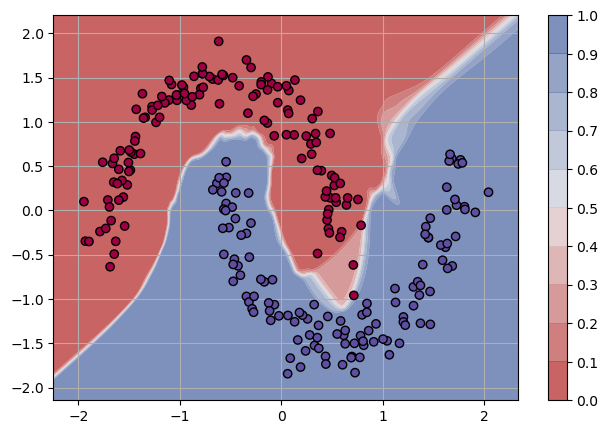

In [13]:
### CREATE A MESHGRID ###
# Create a meshgrid for the whole dataset such that we can plot the predictions for each point
h = .01  # step size in the mesh
buffer = 0.3 # buffer for the axes
x_min, x_max = X[:, 0].min() - buffer, X[:, 0].max() + buffer # min and max of the first feature
y_min, y_max = X[:, 1].min() - buffer, X[:, 1].max() + buffer # min and max of the second feature
xx,yy= np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
grid = np.c_[xx.ravel(), yy.ravel()]
grid = torch.from_numpy((grid - X.mean(axis=0)) / X.std(axis=0)).float().to(DEVICE)
# mincol in red hexa code, axcol in blue hexa code
custom_map = custom_div_cmap(
    11, mincol='#B22222', midcol='0.9', maxcol='#4863A0')

### SEED ###
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

### PREDICT ###
clevels = 9
Z = network.predict(grid) 
# Depending on the loss function, we need to apply an activation function to the output
if "binary_cross_entropy" in network_data["criterion"].__name__:
    Z = Z.cpu().reshape(xx.shape)
else:    
    Z = torch.exp(Z)
    Z = torch.max(Z, dim=1)[0].reshape(xx.shape).cpu()

### PLOT ###
# Plot the predictions with the uncertainty
fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))
ax.grid(True)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Spectral, edgecolors='k', zorder=2)

# Plot the uncertainty with contourf based on the value of Z
c = ax.contourf(xx, yy, Z, alpha=0.7, levels=clevels, antialiased=True, cmap=custom_map, zorder=1)

# Add a colorbar
colorbar = fig.colorbar(c, ax=ax, ticks=np.arange(0, 1.1, 1 / (clevels+1)))
# force the leftbar to be between 0 and 1
c.get_clim()
c.set_clim(0, 1)
colorbar.ax.set_ylim(0, 1)

os.makedirs(SAVE_FOLDER, exist_ok=True)
plt.savefig(os.path.join(SAVE_FOLDER, "two-moons-uncertainty-STE-BiNN.pdf"), bbox_inches='tight')
plt.show()

### DNN

In [14]:

### NETWORK CONFIGURATION ###
network_data = {
    "nn_type": models.DNN,
    "nn_parameters": {
        "layers": [INPUT_SIZE] + LAYER_SIZE + [OUT],
        "device": DEVICE,
        "activation_function": torch.functional.F.relu, # Activation function for hidden layers
        "output_function": OUTPUT_FUNCTION, # Activation function for output layer (as loss function is BCE_with_logits, no activation function is needed)
        "weight_init": "uniform",
        "std": 0.01,
        "dropout": False,
        "batchnorm": False,
    },
    "training_parameters": {
        'n_epochs': EPOCHS,
        'batch_size': BATCH_SIZE,
    },
    "criterion": CRITERION,
    "optimizer": torch.optim.Adam,
    "optimizer_parameters": {
        "lr": LEARNING_RATE,
    },
}

train_tensor = GPUTensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
test_tensor = GPUTensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

if "binary_cross_entropy" in network_data["criterion"].__name__:
    train_tensor.targets = train_tensor.targets.float().unsqueeze(1)
    test_tensor.targets = test_tensor.targets.float().unsqueeze(1)

train_loader = GPUDataLoader(train_tensor, batch_size=network_data["training_parameters"]["batch_size"], shuffle=True)
test_loader = GPUDataLoader(test_tensor, batch_size=te_size, shuffle=False)

### SEED ###
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

### ACCURACY INITIALIZATION ###
accuracies = []
batch_size = network_data['training_parameters']['batch_size']

### NETWORK INITIALIZATION ###
model = network_data['nn_type'](**network_data['nn_parameters'])

### INSTANTIATE THE TRAINER ###
network = trainer.GPUTrainer(batch_size=batch_size,
                                model=model, **network_data, device=DEVICE)
### TRAINING ###
network.fit(
    train_loader, 
    **network_data['training_parameters'], 
    test_loader=[test_loader, train_loader],
    name_loader=["Test accuracy", "Train accuracy"]
)

Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing ac

Epoch 90/3000:   2%|▏         | 68/3000 [00:00<00:13, 220.84it/s, loss=0.687]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing ac

Epoch 136/3000:   4%|▍         | 115/3000 [00:00<00:12, 225.09it/s, loss=0.667]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing ac

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing ac

Epoch 225/3000:   7%|▋         | 209/3000 [00:01<00:12, 225.24it/s, loss=0.561]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing ac

Epoch 266/3000:   8%|▊         | 255/3000 [00:01<00:12, 214.85it/s, loss=0.493]

	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accu

Epoch 311/3000:  10%|█         | 301/3000 [00:01<00:12, 218.38it/s, loss=0.425]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing ac

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing ac

Epoch 396/3000:  13%|█▎        | 392/3000 [00:01<00:11, 221.79it/s, loss=0.341]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing ac

Epoch 441/3000:  15%|█▍        | 438/3000 [00:02<00:11, 218.11it/s, loss=0.318]

	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accu

Epoch 483/3000:  15%|█▌        | 461/3000 [00:02<00:11, 218.92it/s, loss=0.305]

	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train acc

Epoch 526/3000:  17%|█▋        | 505/3000 [00:02<00:11, 209.54it/s, loss=0.295]

	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train acc

Epoch 572/3000:  18%|█▊        | 552/3000 [00:02<00:11, 218.05it/s, loss=0.288]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.40%
Testing ac

Epoch 617/3000:  20%|█▉        | 599/3000 [00:02<00:10, 221.80it/s, loss=0.283]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing ac

Epoch 660/3000:  22%|██▏       | 645/3000 [00:03<00:10, 216.24it/s, loss=0.279]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing ac

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 85.20%
Testing ac

Epoch 741/3000:  24%|██▍       | 733/3000 [00:03<00:10, 208.95it/s, loss=0.273]

Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 85.60%
Testing ac

Epoch 776/3000:  25%|██▌       | 757/3000 [00:03<00:10, 217.11it/s, loss=0.271]

	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train acc

Epoch 814/3000:  27%|██▋       | 801/3000 [00:03<00:11, 196.48it/s, loss=0.269]

Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.00%
Testing ac

	Test accuracy: 90.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accu

Epoch 898/3000:  30%|██▉       | 888/3000 [00:04<00:10, 198.86it/s, loss=0.266]

Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.40%
Testing ac

Epoch 942/3000:  31%|███       | 934/3000 [00:04<00:09, 209.18it/s, loss=0.264]

Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.40%
Testing ac

Epoch 978/3000:  33%|███▎      | 978/3000 [00:04<00:10, 197.81it/s, loss=0.263]

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing ac

Epoch 1014/3000:  33%|███▎      | 999/3000 [00:04<00:10, 185.84it/s, loss=0.262]

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing ac

Epoch 1054/3000:  35%|███▍      | 1039/3000 [00:05<00:10, 190.21it/s, loss=0.261]

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing ac

	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accu

Epoch 1143/3000:  38%|███▊      | 1130/3000 [00:05<00:08, 211.76it/s, loss=0.259]

	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train acc

Epoch 1184/3000:  39%|███▉      | 1174/3000 [00:05<00:08, 213.50it/s, loss=0.258]

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing ac

Epoch 1228/3000:  41%|████      | 1218/3000 [00:05<00:08, 209.89it/s, loss=0.257]

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing ac

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing ac

Epoch 1303/3000:  43%|████▎     | 1281/3000 [00:06<00:08, 191.62it/s, loss=0.255]

	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train acc

Epoch 1343/3000:  44%|████▍     | 1326/3000 [00:06<00:08, 205.69it/s, loss=0.254]

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing ac

Epoch 1375/3000:  46%|████▌     | 1367/3000 [00:06<00:08, 189.93it/s, loss=0.253]

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing ac

Epoch 1407/3000:  47%|████▋     | 1405/3000 [00:06<00:09, 172.13it/s, loss=0.252]

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing ac

Epoch 1442/3000:  48%|████▊     | 1441/3000 [00:07<00:09, 169.06it/s, loss=0.252]

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing ac

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.80%
Testing ac

Epoch 1508/3000:  50%|████▉     | 1495/3000 [00:07<00:08, 168.61it/s, loss=0.25] 

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing ac

Epoch 1543/3000:  51%|█████     | 1531/3000 [00:07<00:08, 163.50it/s, loss=0.249]

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing ac

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing ac

Epoch 1606/3000:  53%|█████▎    | 1603/3000 [00:08<00:08, 159.88it/s, loss=0.247]

	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accu

Epoch 1638/3000:  55%|█████▍    | 1637/3000 [00:08<00:08, 161.08it/s, loss=0.246]

	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train acc

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing ac

Epoch 1702/3000:  56%|█████▋    | 1689/3000 [00:08<00:08, 160.96it/s, loss=0.244]

	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train acc

Epoch 1735/3000:  57%|█████▋    | 1723/3000 [00:08<00:08, 158.56it/s, loss=0.243]

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing ac

	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accu

	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accu

Epoch 1837/3000:  61%|██████    | 1831/3000 [00:09<00:07, 164.82it/s, loss=0.241]

	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accu

Epoch 1867/3000:  62%|██████▏   | 1865/3000 [00:09<00:07, 155.80it/s, loss=0.24] 

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing ac

Epoch 1899/3000:  63%|██████▎   | 1898/3000 [00:09<00:07, 156.93it/s, loss=0.239]

	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train acc

Epoch 1931/3000:  64%|██████▍   | 1915/3000 [00:10<00:06, 159.01it/s, loss=0.238]

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing ac

Epoch 1965/3000:  65%|██████▍   | 1949/3000 [00:10<00:06, 162.85it/s, loss=0.238]

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing ac

Epoch 2000/3000:  66%|██████▌   | 1984/3000 [00:10<00:06, 166.73it/s, loss=0.237]

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing ac

Epoch 2036/3000:  67%|██████▋   | 2021/3000 [00:10<00:05, 171.80it/s, loss=0.236]

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing ac

Epoch 2066/3000:  69%|██████▊   | 2057/3000 [00:10<00:05, 168.69it/s, loss=0.236]

	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accu

Epoch 2101/3000:  70%|██████▉   | 2093/3000 [00:11<00:05, 167.69it/s, loss=0.235]

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing ac

Epoch 2132/3000:  71%|███████   | 2128/3000 [00:11<00:05, 165.68it/s, loss=0.235]

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing ac

Epoch 2161/3000:  72%|███████▏  | 2145/3000 [00:11<00:05, 148.95it/s, loss=0.234]

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing ac

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing ac

Epoch 2226/3000:  74%|███████▍  | 2213/3000 [00:11<00:05, 155.96it/s, loss=0.233]

	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train acc

	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accu

Epoch 2289/3000:  76%|███████▌  | 2280/3000 [00:12<00:04, 161.32it/s, loss=0.232]

	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accu

Epoch 2321/3000:  77%|███████▋  | 2314/3000 [00:12<00:04, 159.97it/s, loss=0.231]

	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train acc

Epoch 2354/3000:  78%|███████▊  | 2348/3000 [00:12<00:04, 160.57it/s, loss=0.231]

	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train acc

Epoch 2384/3000:  79%|███████▉  | 2382/3000 [00:12<00:03, 154.67it/s, loss=0.23] 

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing ac

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing ac

Epoch 2454/3000:  81%|████████  | 2437/3000 [00:13<00:03, 168.87it/s, loss=0.229]

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing ac

Epoch 2484/3000:  82%|████████▏ | 2471/3000 [00:13<00:03, 166.89it/s, loss=0.229]

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing ac

Epoch 2516/3000:  84%|████████▎ | 2505/3000 [00:13<00:03, 160.16it/s, loss=0.228]

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing ac

Epoch 2548/3000:  85%|████████▍ | 2540/3000 [00:13<00:02, 162.62it/s, loss=0.228]

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing ac

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing ac

Epoch 2609/3000:  87%|████████▋ | 2606/3000 [00:14<00:02, 152.43it/s, loss=0.227]

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing ac

Epoch 2640/3000:  88%|████████▊ | 2638/3000 [00:14<00:02, 149.02it/s, loss=0.226]

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing ac

Epoch 2673/3000:  89%|████████▉ | 2672/3000 [00:14<00:02, 154.18it/s, loss=0.226]

	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train acc

Epoch 2706/3000:  90%|████████▉ | 2689/3000 [00:14<00:01, 156.85it/s, loss=0.225]

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing ac

Epoch 2737/3000:  91%|█████████ | 2724/3000 [00:15<00:01, 158.71it/s, loss=0.224]

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing ac

Epoch 2769/3000:  92%|█████████▏| 2757/3000 [00:15<00:01, 156.76it/s, loss=0.224]

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing ac

Epoch 2804/3000:  93%|█████████▎| 2793/3000 [00:15<00:01, 167.07it/s, loss=0.223]

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing ac

Epoch 2832/3000:  94%|█████████▍| 2827/3000 [00:15<00:01, 155.36it/s, loss=0.223]

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing ac

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing ac

Epoch 2894/3000:  96%|█████████▋| 2892/3000 [00:16<00:00, 153.65it/s, loss=0.222]

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing ac

	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train acc

Epoch 2957/3000:  99%|█████████▊| 2957/3000 [00:16<00:00, 154.25it/s, loss=0.221]

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing ac

Epoch 2988/3000:  99%|█████████▉| 2973/3000 [00:16<00:00, 155.40it/s, loss=0.22] 

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing ac

Epoch 3000/3000: 100%|██████████| 3000/3000 [00:16<00:00, 178.53it/s, loss=0.22]


	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%


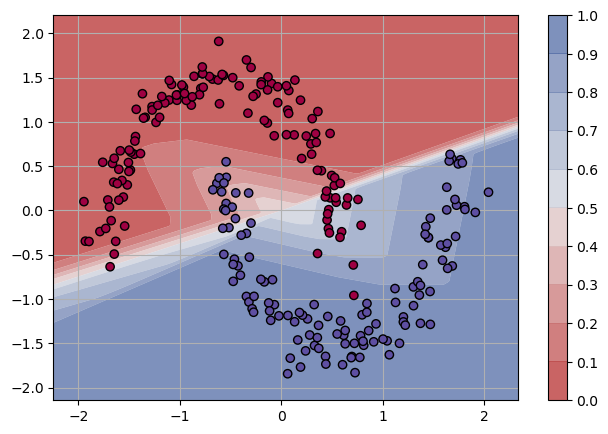

In [15]:
### CREATE A MESHGRID ###
# Create a meshgrid for the whole dataset such that we can plot the predictions for each point
h = .01  # step size in the mesh
buffer = 0.3 # buffer for the axes
x_min, x_max = X[:, 0].min() - buffer, X[:, 0].max() + buffer # min and max of the first feature
y_min, y_max = X[:, 1].min() - buffer, X[:, 1].max() + buffer # min and max of the second feature
xx,yy= np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
grid = np.c_[xx.ravel(), yy.ravel()]
grid = torch.from_numpy((grid - X.mean(axis=0)) / X.std(axis=0)).float().to(DEVICE)
# mincol in red hexa code, axcol in blue hexa code
custom_map = custom_div_cmap(
    11, mincol='#B22222', midcol='0.9', maxcol='#4863A0')

### SEED ###
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

### PREDICT ###
clevels = 9
Z = network.predict(grid) 
# Depending on the loss function, we need to apply an activation function to the output
if "binary_cross_entropy" in network_data["criterion"].__name__:
    Z = Z.cpu().reshape(xx.shape)
else:    
    Z = torch.exp(Z)
    Z = torch.max(Z, dim=1)[0].reshape(xx.shape).cpu()


### PLOT ###
# Plot the predictions with the uncertainty
fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))
ax.grid(True)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Spectral, edgecolors='k', zorder=2)

# Plot the uncertainty with contourf based on the value of Z
c = ax.contourf(xx, yy, Z, alpha=0.7, levels=clevels, antialiased=True, cmap=custom_map, zorder=1)

# Add a colorbar
colorbar = fig.colorbar(c, ax=ax, ticks=np.arange(0, 1.1, 1 / (clevels+1)))
# force the leftbar to be between 0 and 1
c.get_clim()
c.set_clim(0, 1)
colorbar.ax.set_ylim(0, 1)

os.makedirs(SAVE_FOLDER, exist_ok=True)
plt.savefig(os.path.join(SAVE_FOLDER, "two-moons-uncertainty-DNN-Adam.pdf"), bbox_inches='tight')
plt.show()